In [2]:
import numpy as np
import time
import scipy as sp
import pandas as pd
import cPickle as pickle
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.cross_validation import cross_val_score, KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import KMeans
from numpy import genfromtxt
import math
import random
from sklearn import preprocessing

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles

%matplotlib inline 

In [3]:
from sklearn import cluster
from scipy.spatial import distance
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

def compute_bic(kmeans,X):
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2) for i in range(m)])
    
    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

In [4]:
def RF_estimate(clf,X,y):
    if(not(y in clf.classes_)):
        return 0
    res_temp0 = clf.predict_proba(X)
    return res_temp0[:,np.flatnonzero(clf.classes_ == y)]

def max_RF_estimate(clf,X):
    return clf.predict_proba(X).max()

def proximity(clf,X,X1):
    a = clf.apply(X)
    b = clf.apply(X1)
    prox = clf.n_estimators-np.count_nonzero(a-b)
    return prox

# choose the one with highest S1 scores
def S1(clf,X_p,Xr,Xc):
    temp_train = 0.0
    for x0 in Xr:
        temp_train += float(proximity(clf,x0,X_p))
    temp_train /= float(Xr.shape[0])

    temp_test = 0.0
    for x1 in Xc:
        temp_test += float(proximity(clf,x1,X_p))
    temp_test /= float(Xc.shape[0])
    return temp_test/temp_train

# choose the one with highest S2 scores
def S2(clf,X_p,Xr,X):
    temp_test = 0.0
    for x1 in Xc:
        temp_max = max_RF_estimate(clf,x1)
        temp_test += float(proximity(clf,x1,X_p)*(1-temp_max))
    
    temp_train = 0.0
    for x0 in Xr:
        temp_train += float(proximity(clf,x0,X_p))
    temp_train += 1
    return temp_test/temp_train

def plot_with_errbars(N, data):
    x = np.arange(N)
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    valid = ~np.isnan(mean)
    plt.fill_between(x[valid], (mean-2*std)[valid], (mean+2*std)[valid], color='#d0d0d0')
    plt.plot(x[valid], mean[valid])
    
def cluster_obj_and_score_tabel_mean(label_list,obj_uncertainty_score_list,n_cluster):
    cluster_obj_table = []
    cluster_score_table = []
    for i in xrange(n_cluster):
        idx_tmp = np.where(label_list == i)
        cluster_score_tmp = obj_uncertainty_score_list[idx_tmp].mean()
        cluster_obj_table.append(idx_tmp)
        cluster_score_table.append(cluster_score_tmp)
    return cluster_obj_table, cluster_score_table

def find_centroid_table(cluster_obj_table,center_list,n_cluster=10):
    centroid_table = []
    for i in xrange(n_cluster):
        cand_list= np.array(cluster_obj_table[i])[0]
        center_feature = center_list[i]
        tmp=[]
        for j in xrange(cand_list.shape[0]):
            tmp.append(feature_distance(cand_list[j],center_feature))
        centroid_table.append(cand_list[np.argmax(tmp)])
    return centroid_table

def feature_distance(x1,x2):
    det = x1-x2
    s =0
    for i in xrange(det.shape[0]):
        s += det[i]*det[i]
    return math.sqrt(s)

def selected_obj_list(cluster_obj_table, center_list, obj_uncertainty_score_list, Xc, step):
    selected_list = []
    score_list = []
    Xfeature =  Xc[:,:2]
    for i in xrange(len(cluster_obj_table)):
        idx_list = cluster_obj_table[i][0]
        center = center_list[i]
        dist_temp = []
        unct_temp = []
        time_temp = []
        score_temp = []
        for j in xrange(idx_list.shape[0]):
            idx = idx_list[j]
            dist_temp.append(feature_distance(Xfeature[idx],center))
            unct_temp.append(obj_uncertainty_score_list[idx])
           
        dist_temp = np.array(dist_temp)/max(dist_temp)
        unct_temp = np.array(unct_temp)/max(unct_temp)
        
        for j in xrange(dist_temp.shape[0]):
            score_temp.append(math.exp(-dist_temp[j]) + 0.35*unct_temp[j])
        selected_list.append(idx_list[np.argmax(score_temp)])
        score_list.append(np.max(score_temp))
        #i = np.argsort(score_list)[-step:]
    return np.array(selected_list), score_list

def cluster_obj_and_score_tabel_sum(label_list,obj_uncertainty_score_list,n_cluster):
    cluster_obj_table = []
    cluster_score_table = []
    for i in xrange(n_cluster):
        idx_tmp = np.where(label_list == i)
        cluster_score_tmp = obj_uncertainty_score_list[idx_tmp].sum()
        cluster_obj_table.append(idx_tmp)
        cluster_score_table.append(cluster_score_tmp)
    return cluster_obj_table, cluster_score_table

def find_centroid_table(cluster_obj_table,center_list,n_cluster=10):
    centroid_table = []
    for i in xrange(n_cluster):
        cand_list= np.array(cluster_obj_table[i])[0]
        center_feature = center_list[i]
        tmp=[]
        for j in xrange(cand_list.shape[0]):
            tmp.append(feature_distance(cand_list[j],center_feature))
        centroid_table.append(cand_list[np.argmax(tmp)])
    return centroid_table

def max_RF_estimate(clf,X):
    return clf.predict_proba(X).max()

def Top_N_Uncertainty(clf,Xc,N):
    temp_list = np.zeros((Xc.shape[0],1))
    i = 0
    for x in Xc:
        temp_list[i][0] = max_RF_estimate(clf,x)
        i +=1
    return temp_list[:,0].argsort()[:N]



In [5]:
color=['r','b']

# Datasets

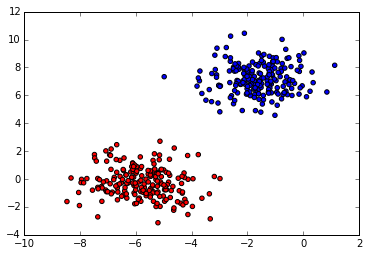

In [6]:
## ds 0
from sklearn.datasets.samples_generator import make_blobs
data_0_X, data_0_y = make_blobs(n_samples=400, centers=2, n_features=2,random_state=22)
cc=[color[i] for i in data_0_y]
plt.scatter(data_0_X[:,0],data_0_X[:,1],c=cc)

cost_0 = [random.uniform(1, 4)+data_0_y[i] for i in xrange(400)]

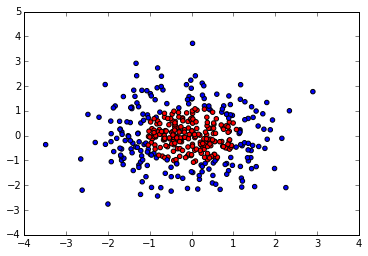

In [7]:
## ds 1
n_sample=400
data_1_X, data_1_y = make_gaussian_quantiles(n_samples=n_sample,n_features=2, n_classes=2)
cc=[color[i] for i in data_1_y]
plt.scatter(data_1_X[:,0],data_1_X[:,1],c=cc)

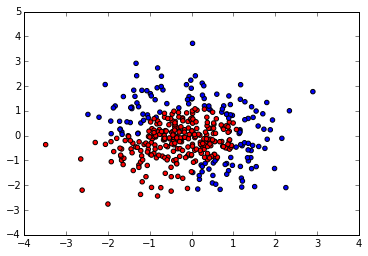

In [8]:
a1 = data_1_X[:,0]<0
a2 = data_1_X[:,1]< 0
a3 = data_1_y == 1
b=np.arange(400)
a = [a1[i] and a2[i] and a3[i] for i in np.arange(n_sample)]
c = b[np.array(a)]
data_1_y[c]=0
cc=[color[i] for i in data_1_y]
plt.scatter(data_1_X[:,0],data_1_X[:,1],c=cc)

cost_1 = [random.uniform(1, 4)+data_1_y[i] for i in xrange(400)]

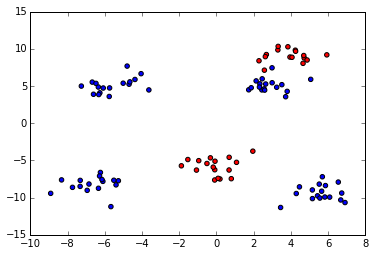

In [9]:
## ds 2
data_2_X, data_2_y_old = make_blobs(n_samples=100, centers=6, n_features=2,random_state=10)
dicty = [1,1,0,1,1,0]
data_2_y = [dicty[i] for i in data_2_y_old]
data_2_y = np.array(data_2_y)
cc=[color[i] for i in data_2_y]
plt.scatter(data_2_X[:,0],data_2_X[:,1],c=cc)

cost_2 = [random.uniform(1, 4)+data_2_y_old[i] for i in xrange(100)]

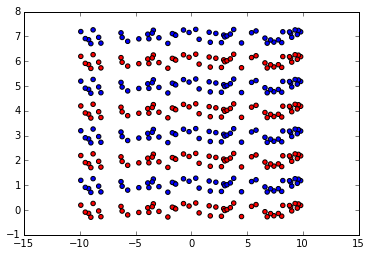

In [10]:
## ds 3
import random
x0_0 = np.array(random.sample(np.arange(-1,1,0.01), 50))
x0_1 = np.array(random.sample(np.arange(-1,1,0.01), 50))
x1_0 = x0_0*10
x1_1 = x0_1*0.3
x1_2 = x1_1+1
x1_3 = x1_1+2
x1_4 = x1_1+3
x1_5 = x1_1+4
x1_6 = x1_1+5
x1_7 = x1_1+6
x1_8 = x1_1+7
y0 = [0 for i in xrange(50)]
y1 = [1 for i in xrange(50)]
x0 = np.hstack([x1_0,x1_0,x1_0,x1_0,x1_0,x1_0,x1_0,x1_0])
x1 = np.hstack([x1_1,x1_2,x1_3,x1_4,x1_5,x1_6,x1_7,x1_8])
data_3_y = np.hstack([y0,y1,y0,y1,y0,y1,y0,y1])

cc=[color[i] for i in data_3_y]
data_3_X = np.vstack([x0,x1])
data_3_X = data_3_X.T
plt.scatter(data_3_X[:,0],data_3_X[:,1],c=cc)

y0 = [0 for i in xrange(50)]
y1 = [1 for i in xrange(50)]
y2 = [2 for i in xrange(50)]
y3 = [3 for i in xrange(50)]
y4 = [4 for i in xrange(50)]
y5 = [5 for i in xrange(50)]
y6 = [6 for i in xrange(50)]
y7 = [7 for i in xrange(50)]

data_3_y_fake = np.hstack([y0,y1,y2,y3,y4,y5,y6,y7])
cost_3  = [random.uniform(1, 4)+data_3_y_fake[i] for i in xrange(400)]

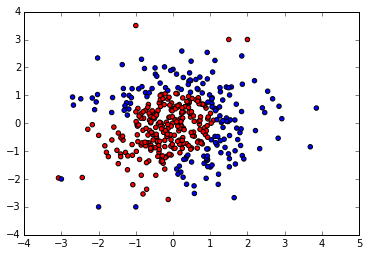

In [11]:
## ds 4
x_temp = np.array([[-3,-2],[-2,-3],[-1,-3],[-1,3.5],[1.5,3],[2,3]])
y_temp = np.array([1,1,1,0,0,0])
data_4_X = np.vstack([data_1_X,x_temp])
data_4_y = np.hstack([data_1_y,y_temp])
cc=[color[i] for i in data_4_y]
plt.scatter(data_4_X[:,0],data_4_X[:,1],c=cc)

cost_4  = [random.uniform(1, 4)+data_4_y[i] for i in xrange(406)]

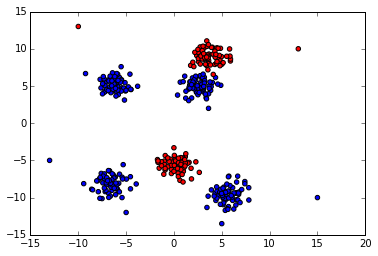

In [12]:
## ds 5
x_temp = np.array([[-13,-5],[-10,13],[-5,-12],[5,-13.5],[15,-10],[13,10]])
y_temp = np.array([1,0,1,1,1,0])
data_5_X = np.vstack([data_2_X,x_temp])
data_5_y = np.hstack([data_2_y,y_temp])
cc=[color[i] for i in data_5_y]
plt.scatter(data_5_X[:,0],data_5_X[:,1],c=cc)

cost_5_temp_0 = [random.uniform(1, 4)+data_2_y_old[i] for i in xrange(400)]
cost_5_temp_1  = [random.uniform(1, 4)+y_temp[i] for i in xrange(6)]
cost_5 = cost_5_temp_0+cost_5_temp_1

In [13]:
## create mat data
def create_mat_data(X_selected):
    Ni=X_selected.shape[0]
    Wpp = np.zeros((Ni,Ni))
    Wpp1 = np.zeros((Ni,Ni))
    Wpp2 = np.zeros((Ni,Ni))
    Wpp3 = np.zeros((Ni,Ni))


    for i in xrange(Ni):
        s=np.sum((X_selected[i,:]-X_selected[i+1:,:])**2, axis=1)

        temp=np.exp(-s)
        Wpp[i,i+1:len(temp)+i+1]=temp
        Wpp[i+1:len(temp)+i+1, i]=temp

        temp1=np.exp(-s/0.01)
        Wpp1[i,i+1:len(temp)+i+1]=temp1
        Wpp1[i+1:len(temp)+i+1, i]=temp1

        temp2=np.exp(-s/0.05)
        Wpp2[i,i+1:len(temp)+i+1]=temp2
        Wpp2[i+1:len(temp)+i+1, i]=temp2

        temp3=np.exp(-s/0.001)
        Wpp3[i,i+1:len(temp)+i+1]=temp3
        Wpp3[i+1:len(temp)+i+1, i]=temp3
    return Wpp,Wpp1,Wpp2,Wpp3

def create_01_data(Y_selected):
    num_class=2
    Y_selected_01 = np.zeros((len(Y_selected),num_class))
    for i in xrange(len(Y_selected)):
        Y_selected_01[i][int(Y_selected[i])]=1
    Y_selected_01.shape
    return Y_selected_01

In [13]:
data_0_X_new= np.zeros((400,3))
data_0_X_new[:,:2] = data_0_X
data_0_X_new[:,-1] = cost_0

data_1_X_new= np.zeros((400,3))
data_1_X_new[:,:2] = data_1_X
data_1_X_new[:,-1] = cost_1

data_2_X_new= np.zeros((100,3))
data_2_X_new[:,:2] = data_2_X
data_2_X_new[:,-1] = cost_2

data_3_X_new= np.zeros((400,3))
data_3_X_new[:,:2] = data_3_X
data_3_X_new[:,-1] = cost_3

data_4_X_new= np.zeros((406,3))
data_4_X_new[:,:2] = data_4_X
data_4_X_new[:,-1] = cost_4

data_5_X_new= np.zeros((406,3))
data_5_X_new[:,:2] = data_5_X
data_5_X_new[:,-1] = cost_5

data_0_X_copy = data_0_X_new
data_0_y_copy = data_0_y

data_1_X_copy = data_1_X_new
data_1_y_copy = data_1_y

data_2_X_copy = data_2_X_new
data_2_y_copy = data_2_y

data_3_X_copy = data_3_X_new
data_3_y_copy = data_3_y

data_4_X_copy = data_4_X_new
data_4_y_copy = data_4_y

data_5_X_copy = data_5_X_new
data_5_y_copy = data_5_y

NameError: name 'data_4_X' is not defined

In [14]:
def sigmoid(x): 
    thred = 0.5
    if x>=thred: return 1
    else: return 0
    
def selected_obj_list_cost(cluster_obj_table, center_list, obj_uncertainty_score_list, Xc,step):
    selected_list = []
    score_list = []
    Xfeature =  Xc[:,:2]
    for i in xrange(len(cluster_obj_table)):
        idx_list = cluster_obj_table[i][0]
        center = center_list[i]
        dist_temp = []
        unct_temp = []
        time_temp = []
        score_temp = []
        for j in xrange(idx_list.shape[0]):
            idx = idx_list[j]
            dist_temp.append(feature_distance(Xfeature[idx],center))
            unct_temp.append(obj_uncertainty_score_list[idx])
            time_temp.append(Xc[idx,-1])
        #print time_temp
        dist_temp = (np.array(dist_temp)-min(dist_temp))/(max(dist_temp)-min(dist_temp))
        unct_temp = np.array(unct_temp)
        time_temp = (np.array(time_temp)-min(time_temp))/(max(time_temp)-min(time_temp))
        #print dist_temp
        for j in xrange(dist_temp.shape[0]):
            score_temp.append(-dist_temp[j] - 0.4*sigmoid(time_temp[j]))
            #score_temp.append(-dist_temp[j] )
            
        selected_list.append(idx_list[np.argmax(score_temp)])
        score_list.append(np.max(score_temp))
    return np.array(selected_list)[np.argsort(score_list)[::-1][:step]]
   
def selected_obj_list_no_cost(cluster_obj_table, center_list, obj_uncertainty_score_list, Xc,step):
    selected_list = []
    score_list = []
    Xfeature =  Xc[:,:2]
    for i in xrange(len(cluster_obj_table)):
        idx_list = cluster_obj_table[i][0]
        center = center_list[i]
        dist_temp = []
        unct_temp = []
        time_temp = []
        score_temp = []
        for j in xrange(idx_list.shape[0]):
            idx = idx_list[j]
            dist_temp.append(feature_distance(Xfeature[idx],center))
            unct_temp.append(obj_uncertainty_score_list[idx])
            time_temp.append(Xc[idx,-1])
        #print time_temp
        dist_temp = (np.array(dist_temp)-min(dist_temp))/(max(dist_temp)-min(dist_temp))
        unct_temp = np.array(unct_temp)
        time_temp = (np.array(time_temp)-min(time_temp))/(max(time_temp)-min(time_temp))
        #print dist_temp
        for j in xrange(dist_temp.shape[0]):
            score_temp.append(-dist_temp[j])
            #score_temp.append(-dist_temp[j] )
            
        selected_list.append(idx_list[np.argmax(score_temp)])
        score_list.append(np.max(score_temp))
    return np.array(selected_list)[np.argsort(score_list)[::-1][:step]]
   

In [15]:
def cluster_obj_and_score_tabel_exp(label_list,obj_uncertainty_score_list,n_cluster):
    cluster_obj_table = []
    cluster_score_table = []
    for i in xrange(n_cluster):
        idx_tmp = np.where(label_list == i)
        unc_sort_list = [np.sort(obj_uncertainty_score_list)[-i]*math.pow(0.8,i-1) for i in xrange(1,obj_uncertainty_score_list.shape[0])]
        cluster_score_tmp = sum(unc_sort_list)
        cluster_obj_table.append(idx_tmp)
        cluster_score_table.append(cluster_score_tmp)
    return cluster_obj_table, cluster_score_table

# Test

In [16]:
ks = range(1,30)
from sklearn import cluster
from scipy.spatial import distance
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [19]:
data_2_X_copy = data_2_X
data_2_y_copy = data_2_y

#2

In [20]:
begin = time.time()

step = 5
num_loops = 2
N=8

acc_list_rand_2 = np.zeros((num_loops,N))
acc_list_top_uncertainty_2 = np.zeros((num_loops,N))
acc_list_S1_3000_top_2 = np.zeros((num_loops,N))
acc_list_S2_3000_top_2 = np.zeros((num_loops,N))
acc_list_KM_dist_uncertainty_no_cost_2 = np.zeros((num_loops,N))
acc_list_KM_dist_uncertainty_cost_2 = np.zeros((num_loops,N))

cost_list_rand_2 = np.zeros((num_loops,N))
cost_list_top_uncertainty_2 = np.zeros((num_loops,N))
cost_list_S1_3000_top_2 = np.zeros((num_loops,N))
cost_list_S2_3000_top_2 = np.zeros((num_loops,N))
cost_list_KM_dist_uncertainty_no_cost_2 = np.zeros((num_loops,N))
cost_list_KM_dist_uncertainty_cost_2 = np.zeros((num_loops,N))

initial_n_cluster=20


for j in xrange(num_loops):
    print "num_loop = ",j
    
    init_list_2 = random.sample(xrange(data_2_X.shape[0]), 1)
    sp.io.savemat('/Users/xidexia/Desktop/299/lib/semi-supervised/initL_2_'+str(j)+'.mat', {'initL':(np.array(init_list_2)).tolist()})
    
    #####################
    # RAND
    #####################
    print " ***RAND*** "
    X_all = data_2_X_copy
    y_all = data_2_y_copy
        
    labeled_list = init_list_2
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_Rand = RandomForestClassifier(n_estimators=100)
    clf_Rand.fit(Xlabel[:,:2], ylabel)
    
    acc_list_rand_2[j,0] = clf_Rand.score(X_all[:,:2], y_all)
   
    for i in xrange(N-1):
        new_selected_list = random.sample(xrange(Xsearch.shape[0]), step)
        cost_list_rand_2[j,i+1] = Xsearch[new_selected_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[new_selected_list]))   
        ylabel = np.append(ylabel,ysearch[new_selected_list])  
        
        Xsearch = np.delete(np.array(Xsearch),new_selected_list,0)
        ysearch = np.delete(np.array(ysearch),new_selected_list,0)  

        clf_Rand = RandomForestClassifier(n_estimators=100)
        clf_Rand.fit(Xlabel[:,:2], ylabel)

        acc_list_rand_2[j,i+1] = clf_Rand.score(X_all[:,:2], y_all)
        
    
    
    #####################
    # TOP UNCERTAINTY
    #####################
    print " ***TOP UNCERTAINTY*** "
    X_all = data_2_X_copy
    y_all = data_2_y_copy
        
    labeled_list = init_list_2
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)    
    
    clf_top_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_top_uncertainty.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_top_uncertainty.predict_proba(Xsearch[:,:2])
    max_test_rf_est_list = 1-test_rf_est_list.max(axis=1)

    acc_list_top_uncertainty_2[j,0] = clf_top_uncertainty.score(X_all[:,:2], y_all)
   
    for i in xrange(N-1):
        Uncertainty_label_list = max_test_rf_est_list.argsort()[-step:]
        cost_list_top_uncertainty_2[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()

        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])  
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_top_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_top_uncertainty.fit(Xlabel[:,:2], ylabel)

        test_rf_est_list = clf_top_uncertainty.predict_proba(Xsearch[:,:2])
        max_test_rf_est_list = 1-test_rf_est_list.max(axis=1)

        acc_list_top_uncertainty_2[j,i+1] = clf_top_uncertainty.score(X_all[:,:2], y_all)
    
    
    #####################
    # S1
    #####################
    print " ***S1*** "
    X_all = data_2_X_copy
    y_all = data_2_y_copy
        
    labeled_list = init_list_2
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)    
    
    clf_S1_3000_top = RandomForestClassifier(n_estimators=100)
    clf_S1_3000_top.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_S1_3000_top.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
    
    acc_list_S1_3000_top_2[j,0] = clf_S1_3000_top.score(X_all[:,:2], y_all)
    
    for i in xrange(N-1):
        PXc = clf_S1_3000_top.apply(Xsearch[:,:2])
        PXlabel = clf_S1_3000_top.apply(Xlabel[:,:2])

        S1_list=[]
        for si in xrange(Xsearch.shape[0]):
            sd = sum([100-np.count_nonzero(PXc[si]-PXlabel[sj]) for sj in xrange(Xlabel.shape[0])])/Xlabel.shape[0]
            sn = sum([100-np.count_nonzero(PXc[si]-PXc[sj]) for sj in xrange(PXc.shape[0])])/PXc.shape[0]
            S1_list.append(1.*sn/sd)

        Uncertainty_label_list = np.argsort(S1_list)[-step:]
        cost_list_S1_3000_top_2[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])  
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_S1_3000_top = RandomForestClassifier(n_estimators=100)
        clf_S1_3000_top.fit(Xlabel[:,:2], ylabel)
        
        acc_list_S1_3000_top_2[j,i+1] = clf_S1_3000_top.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_S1_3000_top.predict_proba(Xsearch[:,:2])
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
        
        
    #####################
    # S2
    #####################
    print " ***S2*** "
    X_all = data_2_X_copy
    y_all = data_2_y_copy
        
    labeled_list = init_list_2
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_S2_3000_top = RandomForestClassifier(n_estimators=100)
    clf_S2_3000_top.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_S2_3000_top.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
    
    acc_list_S2_3000_top_2[j,0] = clf_S2_3000_top.score(X_all[:,:2], y_all)
    
    for i in xrange(N-1):
        PXc = clf_S2_3000_top.apply(Xsearch[:,:2])
        PXlabel = clf_S2_3000_top.apply(Xlabel[:,:2])

        S2_list=[]
        for si in xrange(Xsearch.shape[0]):
            sd = sum([100-np.count_nonzero(PXc[si]-PXlabel[sj]) for sj in xrange(Xlabel.shape[0])])+1
            sn = sum([100-np.count_nonzero(PXc[si]-PXc[sj]) for sj in xrange(PXc.shape[0])])*obj_uncertainty_score_list[si]
            S2_list.append(1.*sn/sd)

        Uncertainty_label_list = np.argsort(S2_list)[-step:]
        cost_list_S2_3000_top_2[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
       
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])    
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_S2_3000_top = RandomForestClassifier(n_estimators=100)
        clf_S2_3000_top.fit(Xlabel[:,:2], ylabel)
        
        acc_list_S2_3000_top_2[j,i+1] = clf_S2_3000_top.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_S2_3000_top.predict_proba(Xsearch[:,:2])
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
    
    
    #####################
    # C-BAL NO COST
    #####################
    print " ***C-BAL NO COST*** "
    X_all = data_2_X_copy
    y_all = data_2_y_copy
        
    labeled_list = init_list_2
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
  
    acc_list_KM_dist_uncertainty_no_cost_2[j,0] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
    cost_list_KM_dist_uncertainty_no_cost_2[j,0] = 0
    
    for i in xrange(N-1):
        X = Xsearch[:,:2]
        KMeans_temp = [KMeans(n_clusters = ih, init="k-means++").fit(X) for ih in ks]

        # now run for each cluster the BIC computation
        BIC = [compute_bic(kmeansi,X) for kmeansi in KMeans_temp]
        n_cluster = initial_n_cluster
        if np.argmax(BIC)+1 > step: 
            n_cluster = np.argmax(BIC)+1 
        
        if(Xsearch.shape[0] < n_cluster): break
            
        kmeans = KMeans(init='k-means++', n_clusters=n_cluster, n_init=10)
        kmeans.fit(Xsearch[:,:2])
        center_list = kmeans.cluster_centers_
        label_list = np.array(kmeans.labels_.tolist())
        cluster_obj_table, cluster_score_table = cluster_obj_and_score_tabel_exp(label_list,obj_uncertainty_score_list,n_cluster)
        
        Uncertainty_label_list = selected_obj_list_no_cost(cluster_obj_table,center_list, obj_uncertainty_score_list, Xsearch,step)       
        cost_list_KM_dist_uncertainty_no_cost_2[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])    
            
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
        
        acc_list_KM_dist_uncertainty_no_cost_2[j,i+1] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])   
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
            
    #####################
    # C-BAL COST
    #####################
    print " ***C-BAL COST*** "
    X_all = data_2_X_copy
    y_all = data_2_y_copy
        
    labeled_list = init_list_2
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
  
    acc_list_KM_dist_uncertainty_cost_2[j,0] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
    cost_list_KM_dist_uncertainty_cost_2[j,0] = 0
    
    for i in xrange(N-1):
        X = Xsearch[:,:2]
        KMeans_temp = [KMeans(n_clusters = ih, init="k-means++").fit(X) for ih in ks]

        # now run for each cluster the BIC computation
        BIC = [compute_bic(kmeansi,X) for kmeansi in KMeans_temp]
        n_cluster = initial_n_cluster
        if np.argmax(BIC)+1 > step: 
            n_cluster = np.argmax(BIC)+1 
        
        if(Xsearch.shape[0] < n_cluster): break
            
        kmeans = KMeans(init='k-means++', n_clusters=n_cluster, n_init=10)
        kmeans.fit(Xsearch[:,:2])
        center_list = kmeans.cluster_centers_
        label_list = np.array(kmeans.labels_.tolist())
        cluster_obj_table, cluster_score_table = cluster_obj_and_score_tabel_exp(label_list,obj_uncertainty_score_list,n_cluster)
        Uncertainty_label_list = selected_obj_list_cost(cluster_obj_table,center_list, obj_uncertainty_score_list, Xsearch,step)
        cost_list_KM_dist_uncertainty_cost_2[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])         
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
        
        acc_list_KM_dist_uncertainty_cost_2[j,i+1] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])   
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
        
 
print 'Time Elapsed:', time.time()-begin 

num_loop =  0
 ***RAND*** 
 ***TOP UNCERTAINTY*** 
 ***S1*** 
 ***S2*** 
 ***C-BAL NO COST*** 
 ***C-BAL COST*** 
num_loop =  1
 ***RAND*** 
 ***TOP UNCERTAINTY*** 
 ***S1*** 
 ***S2*** 
 ***C-BAL NO COST*** 
 ***C-BAL COST*** 
Time Elapsed: 31.4581661224


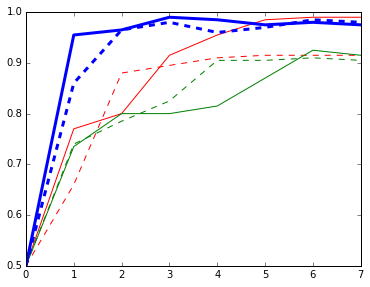

In [23]:
plt.figure(figsize = [6,10])
plt.subplot(2,1,1)
plt.plot(acc_list_rand_2.mean(axis=0),"r-")
plt.plot(acc_list_top_uncertainty_2.mean(axis=0),"r--")
plt.plot(acc_list_S1_3000_top_2.mean(axis=0),"g-")
plt.plot(acc_list_S2_3000_top_2.mean(axis=0),"g--")
plt.plot(acc_list_KM_dist_uncertainty_cost_2.mean(axis=0),"b-",lw=3)
plt.plot(acc_list_KM_dist_uncertainty_no_cost_2.mean(axis=0),"b--",lw=3)
#plt.plot(acc_list_Zhu_2.mean(axis=0),c="lime")


#W

In [24]:
import numpy as np
from scipy.optimize import minimize
from numpy import linalg as LA
   

In [26]:
num_data = 100
labeled_list = init_list_2
X_all = data_2_X_copy
y_all = data_2_y_copy


Xlabel = X_all[labeled_list]
ylabel = y_all[labeled_list]

# T
T = np.zeros((num_data,num_data))
for i in xrange(num_data):
    T[i,i] = 1
for i in labeled_list:
    for j in labeled_list:
        if y_all[i]==y_all[j]:
            T[i,j]=1
        else:
            T[i,j]=-1

# D
W_cur=[1,1]
D = np.zeros((num_data,num_data))

for i in xrange(num_data):
    for j in xrange(num_data):
        D[i,j] = sum(W_cur*((X_all[i,:2]-X_all[j,:2])**2))

In [27]:
def dist(w):
    norm = LA.norm(w, 2)
    part2 = 0    
    for i in xrange(num_data):
        for j in xrange(num_data):
            part2 += max(0,-T[i,j]*D[i,j])
    return norm+part2

In [28]:
res = minimize(dist, W_cur, method='nelder-mead')

In [29]:
res.x

array([ -2.10235293e-05,   2.54845649e-05])

#Z kernel

In [30]:
# S: similarity
num_data = 100
labeled_list = init_list_2
X_all = data_2_X
y_all = data_2_y

from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')
S = dist.pairwise(X_all)
d1 = S.sum(axis=0)
D=  np.diag(d1)
I = np.identity(num_data)


In [32]:

from scipy.sparse import csgraph
L = csgraph.laplacian(S, normed=True)
L = L+0.001*I

Xlabel = X_all[labeled_list]
ylabel = y_all[labeled_list]

# T
T = np.zeros((num_data,num_data))
for i in labeled_list:
    for j in labeled_list:
        if y_all[i] == y_all[j]:
            T[i,j]=1
        else:
            T[i,j]=-1


In [49]:
num_data=100
Z_cur = np.random.rand(1,num_data*num_data)*2-1
def Z_obj(Z):
    Z = Z.reshape((num_data,num_data))
    #print "======="
    #print Z
    norm = np.trace(L*Z)
    part2 = 0    
    for i in labeled_list:
        for j in labeled_list:
            part2 += max(0,1-T[i,j]*Z[i,j])
    
    return norm + part2

In [50]:
Z_obj(Z_cur)

10.85556113027747

In [51]:
import cvxopt 

In [56]:
res_Z = minimize(Z_obj, Z_cur, method='Nelder-Mead', options={'gtol': 1e-2,'maxiter' :100,'disp' :True})

/Users/xidexia/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: OptimizeWarning: Unknown solver options: gtol
  if __name__ == '__main__':


In [57]:
res_Z.show_options

AttributeError: show_options

In [140]:
a = L*Z
np.matrix.trace(a)

400.0

In [138]:
a

array([[  1.00000000e+00,  -3.12568772e-03,  -3.98840859e-03, ...,
         -3.94424392e-03,  -2.67534002e-03,  -2.19800531e-03],
       [ -3.12568772e-03,   1.00000000e+00,  -1.55979484e-03, ...,
         -1.60308883e-03,  -3.38310634e-03,  -2.96205389e-03],
       [ -3.98840859e-03,  -1.55979484e-03,   1.00000000e+00, ...,
         -2.24848838e-04,  -3.87418644e-03,  -3.63437603e-03],
       ..., 
       [ -3.94424392e-03,  -1.60308883e-03,  -2.24848838e-04, ...,
          1.00000000e+00,  -3.85867918e-03,  -3.56175483e-03],
       [ -2.67534002e-03,  -3.38310634e-03,  -3.87418644e-03, ...,
         -3.85867918e-03,   1.00000000e+00,  -1.30143100e-03],
       [ -2.19800531e-03,  -2.96205389e-03,  -3.63437603e-03, ...,
         -3.56175483e-03,  -1.30143100e-03,   1.00000000e+00]])

# 2

In [563]:
begin = time.time()

step = 5
num_loops = 5
N=8

acc_list_rand_2 = np.zeros((num_loops,N))
acc_list_top_uncertainty_2 = np.zeros((num_loops,N))
acc_list_S1_3000_top_2 = np.zeros((num_loops,N))
acc_list_S2_3000_top_2 = np.zeros((num_loops,N))
acc_list_KM_dist_uncertainty_no_cost_2 = np.zeros((num_loops,N))
acc_list_KM_dist_uncertainty_cost_2 = np.zeros((num_loops,N))

cost_list_rand_2 = np.zeros((num_loops,N))
cost_list_top_uncertainty_2 = np.zeros((num_loops,N))
cost_list_S1_3000_top_2 = np.zeros((num_loops,N))
cost_list_S2_3000_top_2 = np.zeros((num_loops,N))
cost_list_KM_dist_uncertainty_no_cost_2 = np.zeros((num_loops,N))
cost_list_KM_dist_uncertainty_cost_2 = np.zeros((num_loops,N))

initial_n_cluster=20


for j in xrange(num_loops):
    print "num_loop = ",j
    
    init_list_2 = random.sample(xrange(data_2_X.shape[0]), 1)
    sp.io.savemat('/Users/xidexia/Desktop/299/lib/semi-supervised/initL_2_'+str(j)+'.mat', {'initL':(np.array(init_list_2)).tolist()})
    
    #####################
    # RAND
    #####################
    print " ***RAND*** "
    X_all = data_2_X_copy
    y_all = data_2_y_copy
        
    labeled_list = init_list_2
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_Rand = RandomForestClassifier(n_estimators=100)
    clf_Rand.fit(Xlabel[:,:2], ylabel)
    
    acc_list_rand_2[j,0] = clf_Rand.score(X_all[:,:2], y_all)
   
    for i in xrange(N-1):
        new_selected_list = random.sample(xrange(Xsearch.shape[0]), step)
        cost_list_rand_2[j,i+1] = Xsearch[new_selected_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[new_selected_list]))   
        ylabel = np.append(ylabel,ysearch[new_selected_list])  
        
        Xsearch = np.delete(np.array(Xsearch),new_selected_list,0)
        ysearch = np.delete(np.array(ysearch),new_selected_list,0)  

        clf_Rand = RandomForestClassifier(n_estimators=100)
        clf_Rand.fit(Xlabel[:,:2], ylabel)

        acc_list_rand_2[j,i+1] = clf_Rand.score(X_all[:,:2], y_all)
        
    
    
    #####################
    # TOP UNCERTAINTY
    #####################
    print " ***TOP UNCERTAINTY*** "
    X_all = data_2_X_copy
    y_all = data_2_y_copy
        
    labeled_list = init_list_2
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)    
    
    clf_top_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_top_uncertainty.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_top_uncertainty.predict_proba(Xsearch[:,:2])
    max_test_rf_est_list = 1-test_rf_est_list.max(axis=1)

    acc_list_top_uncertainty_2[j,0] = clf_top_uncertainty.score(X_all[:,:2], y_all)
   
    for i in xrange(N-1):
        Uncertainty_label_list = max_test_rf_est_list.argsort()[-step:]
        cost_list_top_uncertainty_2[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()

        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])  
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_top_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_top_uncertainty.fit(Xlabel[:,:2], ylabel)

        test_rf_est_list = clf_top_uncertainty.predict_proba(Xsearch[:,:2])
        max_test_rf_est_list = 1-test_rf_est_list.max(axis=1)

        acc_list_top_uncertainty_2[j,i+1] = clf_top_uncertainty.score(X_all[:,:2], y_all)
    
    
    #####################
    # S1
    #####################
    print " ***S1*** "
    X_all = data_2_X_copy
    y_all = data_2_y_copy
        
    labeled_list = init_list_2
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)    
    
    clf_S1_3000_top = RandomForestClassifier(n_estimators=100)
    clf_S1_3000_top.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_S1_3000_top.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
    
    acc_list_S1_3000_top_2[j,0] = clf_S1_3000_top.score(X_all[:,:2], y_all)
    
    for i in xrange(N-1):
        PXc = clf_S1_3000_top.apply(Xsearch[:,:2])
        PXlabel = clf_S1_3000_top.apply(Xlabel[:,:2])

        S1_list=[]
        for si in xrange(Xsearch.shape[0]):
            sd = sum([100-np.count_nonzero(PXc[si]-PXlabel[sj]) for sj in xrange(Xlabel.shape[0])])/Xlabel.shape[0]
            sn = sum([100-np.count_nonzero(PXc[si]-PXc[sj]) for sj in xrange(PXc.shape[0])])/PXc.shape[0]
            S1_list.append(1.*sn/sd)

        Uncertainty_label_list = np.argsort(S1_list)[-step:]
        cost_list_S1_3000_top_2[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])  
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_S1_3000_top = RandomForestClassifier(n_estimators=100)
        clf_S1_3000_top.fit(Xlabel[:,:2], ylabel)
        
        acc_list_S1_3000_top_2[j,i+1] = clf_S1_3000_top.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_S1_3000_top.predict_proba(Xsearch[:,:2])
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
        
        
    #####################
    # S2
    #####################
    print " ***S2*** "
    X_all = data_2_X_copy
    y_all = data_2_y_copy
        
    labeled_list = init_list_2
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_S2_3000_top = RandomForestClassifier(n_estimators=100)
    clf_S2_3000_top.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_S2_3000_top.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
    
    acc_list_S2_3000_top_2[j,0] = clf_S2_3000_top.score(X_all[:,:2], y_all)
    
    for i in xrange(N-1):
        PXc = clf_S2_3000_top.apply(Xsearch[:,:2])
        PXlabel = clf_S2_3000_top.apply(Xlabel[:,:2])

        S2_list=[]
        for si in xrange(Xsearch.shape[0]):
            sd = sum([100-np.count_nonzero(PXc[si]-PXlabel[sj]) for sj in xrange(Xlabel.shape[0])])+1
            sn = sum([100-np.count_nonzero(PXc[si]-PXc[sj]) for sj in xrange(PXc.shape[0])])*obj_uncertainty_score_list[si]
            S2_list.append(1.*sn/sd)

        Uncertainty_label_list = np.argsort(S2_list)[-step:]
        cost_list_S2_3000_top_2[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
       
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])    
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_S2_3000_top = RandomForestClassifier(n_estimators=100)
        clf_S2_3000_top.fit(Xlabel[:,:2], ylabel)
        
        acc_list_S2_3000_top_2[j,i+1] = clf_S2_3000_top.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_S2_3000_top.predict_proba(Xsearch[:,:2])
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
    
    
    #####################
    # C-BAL NO COST
    #####################
    print " ***C-BAL NO COST*** "
    X_all = data_2_X_copy
    y_all = data_2_y_copy
        
    labeled_list = init_list_2
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
  
    acc_list_KM_dist_uncertainty_no_cost_2[j,0] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
    cost_list_KM_dist_uncertainty_no_cost_2[j,0] = 0
    
    for i in xrange(N-1):
        X = Xsearch[:,:2]
        KMeans_temp = [KMeans(n_clusters = ih, init="k-means++").fit(X) for ih in ks]

        # now run for each cluster the BIC computation
        BIC = [compute_bic(kmeansi,X) for kmeansi in KMeans_temp]
        n_cluster = initial_n_cluster
        if np.argmax(BIC)+1 > step: 
            n_cluster = np.argmax(BIC)+1 
        
        if(Xsearch.shape[0] < n_cluster): break
            
        kmeans = KMeans(init='k-means++', n_clusters=n_cluster, n_init=10)
        kmeans.fit(Xsearch[:,:2])
        center_list = kmeans.cluster_centers_
        label_list = np.array(kmeans.labels_.tolist())
        cluster_obj_table, cluster_score_table = cluster_obj_and_score_tabel_exp(label_list,obj_uncertainty_score_list,n_cluster)
        
        Uncertainty_label_list = selected_obj_list_no_cost(cluster_obj_table,center_list, obj_uncertainty_score_list, Xsearch,step)       
        cost_list_KM_dist_uncertainty_no_cost_2[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])    
            
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
        
        acc_list_KM_dist_uncertainty_no_cost_2[j,i+1] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])   
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
            
    #####################
    # C-BAL COST
    #####################
    print " ***C-BAL COST*** "
    X_all = data_2_X_copy
    y_all = data_2_y_copy
        
    labeled_list = init_list_2
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
  
    acc_list_KM_dist_uncertainty_cost_2[j,0] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
    cost_list_KM_dist_uncertainty_cost_2[j,0] = 0
    
    for i in xrange(N-1):
        X = Xsearch[:,:2]
        KMeans_temp = [KMeans(n_clusters = ih, init="k-means++").fit(X) for ih in ks]

        # now run for each cluster the BIC computation
        BIC = [compute_bic(kmeansi,X) for kmeansi in KMeans_temp]
        n_cluster = initial_n_cluster
        if np.argmax(BIC)+1 > step: 
            n_cluster = np.argmax(BIC)+1 
        
        if(Xsearch.shape[0] < n_cluster): break
            
        kmeans = KMeans(init='k-means++', n_clusters=n_cluster, n_init=10)
        kmeans.fit(Xsearch[:,:2])
        center_list = kmeans.cluster_centers_
        label_list = np.array(kmeans.labels_.tolist())
        cluster_obj_table, cluster_score_table = cluster_obj_and_score_tabel_exp(label_list,obj_uncertainty_score_list,n_cluster)
        Uncertainty_label_list = selected_obj_list_cost(cluster_obj_table,center_list, obj_uncertainty_score_list, Xsearch,step)
        cost_list_KM_dist_uncertainty_cost_2[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])         
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
        
        acc_list_KM_dist_uncertainty_cost_2[j,i+1] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])   
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
        
 
print 'Time Elapsed:', time.time()-begin 

num_loop =  0
 ***RAND*** 
 ***TOP UNCERTAINTY*** 
 ***S1*** 
 ***S2*** 
 ***C-BAL NO COST*** 
 ***C-BAL COST*** 
num_loop =  1
 ***RAND*** 
 ***TOP UNCERTAINTY*** 
 ***S1*** 
 ***S2*** 
 ***C-BAL NO COST*** 
 ***C-BAL COST*** 
num_loop =  2
 ***RAND*** 
 ***TOP UNCERTAINTY*** 
 ***S1*** 
 ***S2*** 
 ***C-BAL NO COST*** 
 ***C-BAL COST*** 
num_loop =  3
 ***RAND*** 
 ***TOP UNCERTAINTY*** 
 ***S1*** 
 ***S2*** 
 ***C-BAL NO COST*** 
 ***C-BAL COST*** 
num_loop =  4
 ***RAND*** 
 ***TOP UNCERTAINTY*** 
 ***S1*** 
 ***S2*** 
 ***C-BAL NO COST*** 
 ***C-BAL COST*** 
Time Elapsed: 270.827913046


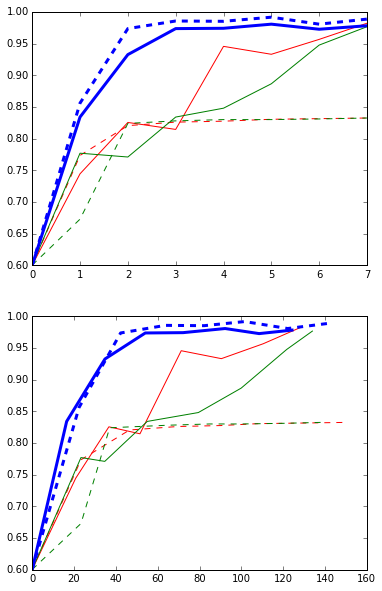

In [564]:
plt.figure(figsize = [6,10])
plt.subplot(2,1,1)
plt.plot(acc_list_rand_2.mean(axis=0),"r-")
plt.plot(acc_list_top_uncertainty_2.mean(axis=0),"r--")
plt.plot(acc_list_S1_3000_top_2.mean(axis=0),"g-")
plt.plot(acc_list_S2_3000_top_2.mean(axis=0),"g--")
plt.plot(acc_list_KM_dist_uncertainty_cost_2.mean(axis=0),"b-",lw=3)
plt.plot(acc_list_KM_dist_uncertainty_no_cost_2.mean(axis=0),"b--",lw=3)

plt.subplot(2,1,2)
plt.plot(cost_list_rand_2.mean(axis=0).cumsum(),acc_list_rand_2.mean(axis=0),"r-")
plt.plot(cost_list_top_uncertainty_2.mean(axis=0).cumsum(),acc_list_top_uncertainty_2.mean(axis=0),"r--")
plt.plot(cost_list_S1_3000_top_2.mean(axis=0).cumsum(),acc_list_S1_3000_top_2.mean(axis=0),"g-")
plt.plot(cost_list_S2_3000_top_2.mean(axis=0).cumsum(),acc_list_S2_3000_top_2.mean(axis=0),"g--")
plt.plot(cost_list_KM_dist_uncertainty_cost_2.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost_2.mean(axis=0),"b-",lw=3)
plt.plot(cost_list_KM_dist_uncertainty_no_cost_2.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_no_cost_2.mean(axis=0),"b--",lw=3)


In [617]:


step = 5
num_loops = 5
N=8

acc_list_Zhu_2 = np.zeros((num_loops,N))
cost_list_Zhu_2 = np.zeros((num_loops,N))

begin = time.time()

for j in xrange(num_loops):
    #####################
    # ZHU
    #####################
    print " ***ZHU*** "
    query0 = sp.io.loadmat('/Users/xidexia/Desktop/query2_'+str(j)+'.mat')['query2_'+str(j)][0]
    
    X_all = data_2_X_copy
    y_all = data_2_y_copy
        
    labeled_list = sp.io.loadmat('/Users/xidexia/Desktop/299/lib/semi-supervised/initL_2_'+str(j)+'.mat')['initL'][0]
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_Rand = RandomForestClassifier(n_estimators=100)
    clf_Rand.fit(Xlabel[:,:2], ylabel)
    
    acc_list_Zhu_2[j,0] = clf_Rand.score(X_all[:,:2], y_all)
  
    for i in xrange(N-1):
        Uncertainty_label_list = query0[i*step:i*step+step]-1
        cost_list_Zhu_2[j,i+1] = X_all[Uncertainty_label_list,-1].sum()
        Xlabel = np.vstack((Xlabel,X_all[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,y_all[Uncertainty_label_list])    
        
        clf_Rand = RandomForestClassifier(n_estimators=100)
        clf_Rand.fit(Xlabel[:,:2], ylabel)

        acc_list_Zhu_2[j,i+1] = clf_Rand.score(X_all[:,:2], y_all)
 
print 'Time Elapsed:', time.time()-begin 

 ***ZHU*** 
 ***ZHU*** 
 ***ZHU*** 
 ***ZHU*** 
 ***ZHU*** 
Time Elapsed: 3.43777108192


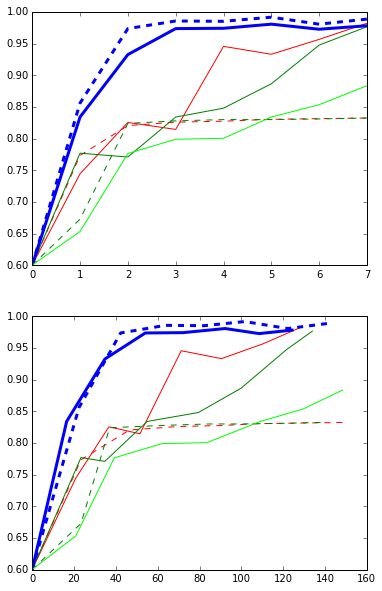

In [618]:
plt.figure(figsize = [6,10])
plt.subplot(2,1,1)
plt.plot(acc_list_rand_2.mean(axis=0),"r-")
plt.plot(acc_list_top_uncertainty_2.mean(axis=0),"r--")
plt.plot(acc_list_S1_3000_top_2.mean(axis=0),"g-")
plt.plot(acc_list_S2_3000_top_2.mean(axis=0),"g--")
plt.plot(acc_list_KM_dist_uncertainty_cost_2.mean(axis=0),"b-",lw=3)
plt.plot(acc_list_KM_dist_uncertainty_no_cost_2.mean(axis=0),"b--",lw=3)
plt.plot(acc_list_Zhu_2.mean(axis=0),c="lime")

plt.subplot(2,1,2)
plt.plot(cost_list_rand_2.mean(axis=0).cumsum(),acc_list_rand_2.mean(axis=0),"r-")
plt.plot(cost_list_top_uncertainty_2.mean(axis=0).cumsum(),acc_list_top_uncertainty_2.mean(axis=0),"r--")
plt.plot(cost_list_S1_3000_top_2.mean(axis=0).cumsum(),acc_list_S1_3000_top_2.mean(axis=0),"g-")
plt.plot(cost_list_S2_3000_top_2.mean(axis=0).cumsum(),acc_list_S2_3000_top_2.mean(axis=0),"g--")
plt.plot(cost_list_KM_dist_uncertainty_cost_2.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost_2.mean(axis=0),"b-",lw=3)
plt.plot(cost_list_KM_dist_uncertainty_no_cost_2.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_no_cost_2.mean(axis=0),"b--",lw=3)
plt.plot(cost_list_Zhu_2.mean(axis=0).cumsum(),acc_list_Zhu_2.mean(axis=0),c="lime")


# 3

num_loop =  0
 ***C-BAL NO COST*** 


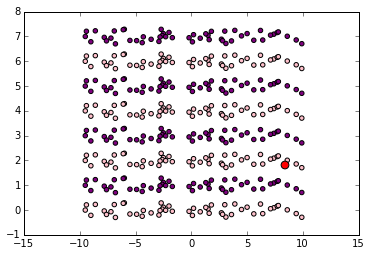

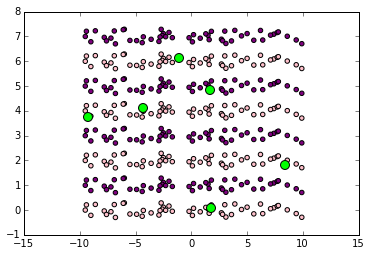

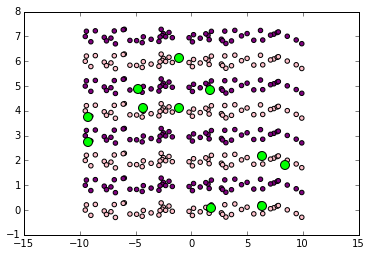

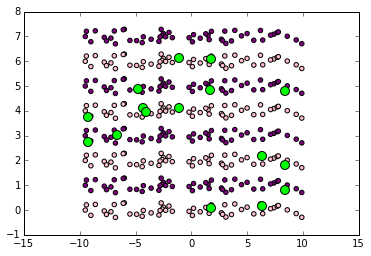

Time Elapsed: 1.81908512115


In [37]:
begin = time.time()

step = 5
num_loops = 1
N=4

acc_list_rand_3 = np.zeros((num_loops,N))
acc_list_top_uncertainty_3 = np.zeros((num_loops,N))
acc_list_S1_3000_top_3 = np.zeros((num_loops,N))
acc_list_S2_3000_top_3 = np.zeros((num_loops,N))
acc_list_KM_dist_uncertainty_no_cost_3 = np.zeros((num_loops,N))
acc_list_KM_dist_uncertainty_cost_3 = np.zeros((num_loops,N))

cost_list_rand_3 = np.zeros((num_loops,N))
cost_list_top_uncertainty_3 = np.zeros((num_loops,N))
cost_list_S1_3000_top_3 = np.zeros((num_loops,N))
cost_list_S2_3000_top_3 = np.zeros((num_loops,N))
cost_list_KM_dist_uncertainty_no_cost_3 = np.zeros((num_loops,N))
cost_list_KM_dist_uncertainty_cost_3 = np.zeros((num_loops,N))

initial_n_cluster=30


for j in xrange(num_loops):
    print "num_loop = ",j
    #####################
    # C-BAL NO COST
    #####################
    print " ***C-BAL NO COST*** "
    X_all = data_3_X_copy
    y_all = data_3_y_copy
        
    labeled_list = init_list_3
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
  
    acc_list_KM_dist_uncertainty_no_cost_3[j,0] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
    
    plt.scatter(data_3_X[:,0],data_3_X[:,1],c=cc)
    plt.scatter(Xlabel[:,0],Xlabel[:,1],c="red",s=60)
    plt.show()
    
    
    #print step
    for i in xrange(N-1):       
        n_cluster = initial_n_cluster
        """
        X = Xsearch[:,:2]
        KMeans_temp = [KMeans(n_clusters = ih, init="k-means++").fit(X) for ih in ks]

        # now run for each cluster the BIC computation
        BIC = [compute_bic(kmeansi,X) for kmeansi in KMeans_temp]
        n_cluster = initial_n_cluster
        if np.argmax(BIC)+1 > step: 
            n_cluster = np.argmax(BIC)+1 
        print n_cluster,step
        """
        
        if(Xsearch.shape[0] < n_cluster): break
            
        kmeans = KMeans(init='k-means++', n_clusters=n_cluster, n_init=10)
        kmeans.fit(Xsearch[:,:2])
        center_list = kmeans.cluster_centers_
        label_list = np.array(kmeans.labels_.tolist())
        cluster_obj_table, cluster_score_table = cluster_obj_and_score_tabel_exp(label_list,obj_uncertainty_score_list,n_cluster)
        Uncertainty_label_list = selected_obj_list_no_cost(cluster_obj_table,center_list, obj_uncertainty_score_list, Xsearch,step)

        cost_list_KM_dist_uncertainty_no_cost_3[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
        #centroid_table = find_centroid_table(cluster_obj_table,center_list,n_cluster=n_cluster)
        #idx = np.argsort(cluster_score_table)[-step:] 
        #Uncertainty_label_list = np.array(centroid_table)[idx]
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])  
        
        plt.scatter(data_3_X[:,0],data_3_X[:,1],c=cc)
        plt.scatter(Xlabel[:,0],Xlabel[:,1],c="lime",s=80)
        plt.show()
    
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
        
        acc_list_KM_dist_uncertainty_no_cost_3[j,i+1] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])   
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
            
   
print 'Time Elapsed:', time.time()-begin 

 ***ZHU*** 


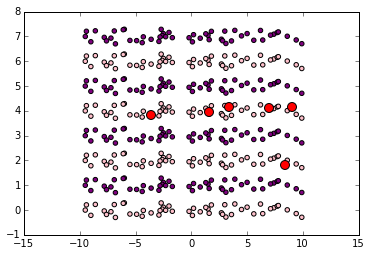

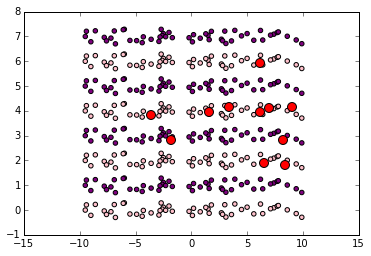

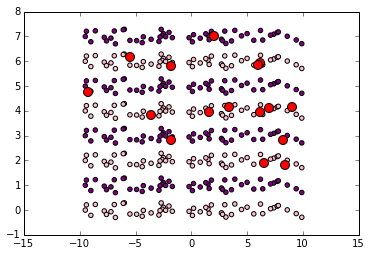

Time Elapsed: 0.954680919647


In [38]:
step = 5
num_loops = 1
N=4

acc_list_Zhu_3 = np.zeros((num_loops,N))
cost_list_Zhu_3 = np.zeros((num_loops,N))

begin = time.time()

for j in xrange(num_loops):
    #####################
    # ZHU
    #####################
    print " ***ZHU*** "
    query0 = sp.io.loadmat('/Users/xidexia/Desktop/query3_'+str(j)+'.mat')['query3_'+str(j)][0]
    
    X_all = data_3_X_copy
    y_all = data_3_y_copy
        
    labeled_list = sp.io.loadmat('/Users/xidexia/Desktop/299/lib/semi-supervised/initL_3_'+str(j)+'.mat')['initL'][0]
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_Rand = RandomForestClassifier(n_estimators=100)
    clf_Rand.fit(Xlabel[:,:2], ylabel)
    
    acc_list_Zhu_3[j,0] = clf_Rand.score(X_all[:,:2], y_all)
  
    for i in xrange(N-1):
        Uncertainty_label_list = query0[i*step:i*step+step]-1
        cost_list_Zhu_3[j,i+1] = X_all[Uncertainty_label_list,-1].sum()
        Xlabel = np.vstack((Xlabel,X_all[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,y_all[Uncertainty_label_list])   
        
        plt.scatter(data_3_X[:,0],data_3_X[:,1],c=cc)
        plt.scatter(Xlabel[:,0],Xlabel[:,1],c="red",s=80)
        plt.show()
        
        clf_Rand = RandomForestClassifier(n_estimators=100)
        clf_Rand.fit(Xlabel[:,:2], ylabel)

        acc_list_Zhu_3[j,i+1] = clf_Rand.score(X_all[:,:2], y_all)
 
print 'Time Elapsed:', time.time()-begin 

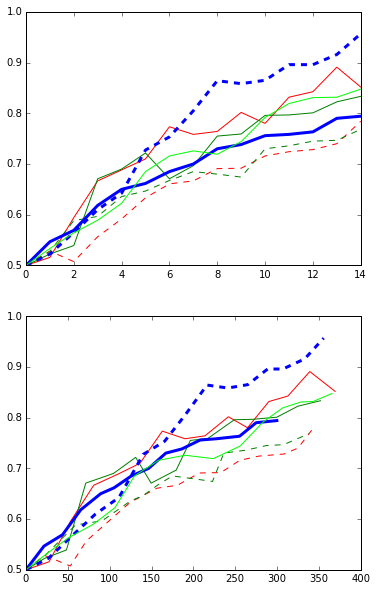

In [620]:
plt.figure(figsize = [6,10])
plt.subplot(2,1,1)
plt.plot(acc_list_rand_3.mean(axis=0),"r-")
plt.plot(acc_list_top_uncertainty_3.mean(axis=0),"r--")
plt.plot(acc_list_S1_3000_top_3.mean(axis=0),"g-")
plt.plot(acc_list_S2_3000_top_3.mean(axis=0),"g--")
plt.plot(acc_list_KM_dist_uncertainty_cost_3.mean(axis=0),"b-",lw=3)
plt.plot(acc_list_KM_dist_uncertainty_no_cost_3.mean(axis=0),"b--",lw=3)
plt.plot(acc_list_Zhu_3.mean(axis=0),c="lime")

plt.subplot(2,1,2)
plt.plot(cost_list_rand_3.mean(axis=0).cumsum(),acc_list_rand_3.mean(axis=0),"r-")
plt.plot(cost_list_top_uncertainty_3.mean(axis=0).cumsum(),acc_list_top_uncertainty_3.mean(axis=0),"r--")
plt.plot(cost_list_S1_3000_top_3.mean(axis=0).cumsum(),acc_list_S1_3000_top_3.mean(axis=0),"g-")
plt.plot(cost_list_S2_3000_top_3.mean(axis=0).cumsum(),acc_list_S2_3000_top_3.mean(axis=0),"g--")
plt.plot(cost_list_KM_dist_uncertainty_cost_3.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost_3.mean(axis=0),"b-",lw=3)
plt.plot(cost_list_KM_dist_uncertainty_no_cost_3.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_no_cost_3.mean(axis=0),"b--",lw=3)
plt.plot(cost_list_Zhu_3.mean(axis=0).cumsum(),acc_list_Zhu_3.mean(axis=0),c="lime")


# 4

In [573]:
begin = time.time()

step = 5
num_loops = 3
N=8

acc_list_rand_4 = np.zeros((num_loops,N))
acc_list_top_uncertainty_4 = np.zeros((num_loops,N))
acc_list_S1_3000_top_4 = np.zeros((num_loops,N))
acc_list_S2_3000_top_4 = np.zeros((num_loops,N))
acc_list_KM_dist_uncertainty_no_cost_4 = np.zeros((num_loops,N))
acc_list_KM_dist_uncertainty_cost_4 = np.zeros((num_loops,N))

cost_list_rand_4 = np.zeros((num_loops,N))
cost_list_top_uncertainty_4 = np.zeros((num_loops,N))
cost_list_S1_3000_top_4 = np.zeros((num_loops,N))
cost_list_S2_3000_top_4 = np.zeros((num_loops,N))
cost_list_KM_dist_uncertainty_no_cost_4 = np.zeros((num_loops,N))
cost_list_KM_dist_uncertainty_cost_4 = np.zeros((num_loops,N))

initial_n_cluster=20

X = data_4_X_copy[:,:2]
KMeans_temp = [KMeans(n_clusters = ih, init="k-means++").fit(X) for ih in ks]

# now run for each cluster the BIC computation
BIC = [compute_bic(kmeansi,X) for kmeansi in KMeans_temp]
n_cluster = initial_n_cluster
if np.argmax(BIC)+1 > step: 
    n_cluster = np.argmax(BIC)+1 

for j in xrange(num_loops):
    print "num_loop = ",j
    
    init_list_4 = random.sample(xrange(data_4_X.shape[0]), 1)
    sp.io.savemat('/Users/xidexia/Desktop/299/lib/semi-supervised/initL_4_'+str(j)+'.mat', {'initL':(np.array(init_list_4)).tolist()})
    
    #####################
    # RAND
    #####################
    print " ***RAND*** "
    X_all = data_4_X_copy
    y_all = data_4_y_copy
        
    labeled_list = init_list_4
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_Rand = RandomForestClassifier(n_estimators=100)
    clf_Rand.fit(Xlabel[:,:2], ylabel)
    
    acc_list_rand_4[j,0] = clf_Rand.score(X_all[:,:2], y_all)
   
    for i in xrange(N-1):
        new_selected_list = random.sample(xrange(Xsearch.shape[0]), step)
        cost_list_rand_4[j,i+1] = Xsearch[new_selected_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[new_selected_list]))   
        ylabel = np.append(ylabel,ysearch[new_selected_list])  
        
        Xsearch = np.delete(np.array(Xsearch),new_selected_list,0)
        ysearch = np.delete(np.array(ysearch),new_selected_list,0)  

        clf_Rand = RandomForestClassifier(n_estimators=100)
        clf_Rand.fit(Xlabel[:,:2], ylabel)

        acc_list_rand_4[j,i+1] = clf_Rand.score(X_all[:,:2], y_all)
        
    
    
    #####################
    # TOP UNCERTAINTY
    #####################
    print " ***TOP UNCERTAINTY*** "
    X_all = data_4_X_copy
    y_all = data_4_y_copy
        
    labeled_list = init_list_4
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)    
    
    clf_top_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_top_uncertainty.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_top_uncertainty.predict_proba(Xsearch[:,:2])
    max_test_rf_est_list = 1-test_rf_est_list.max(axis=1)

    acc_list_top_uncertainty_4[j,0] = clf_top_uncertainty.score(X_all[:,:2], y_all)
   
    for i in xrange(N-1):
        Uncertainty_label_list = max_test_rf_est_list.argsort()[-step:]
        cost_list_top_uncertainty_4[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()

        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])  
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_top_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_top_uncertainty.fit(Xlabel[:,:2], ylabel)

        test_rf_est_list = clf_top_uncertainty.predict_proba(Xsearch[:,:2])
        max_test_rf_est_list = 1-test_rf_est_list.max(axis=1)

        acc_list_top_uncertainty_4[j,i+1] = clf_top_uncertainty.score(X_all[:,:2], y_all)
    
    
    #####################
    # S1
    #####################
    print " ***S1*** "
    X_all = data_4_X_copy
    y_all = data_4_y_copy
        
    labeled_list = init_list_4
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)    
    
    clf_S1_3000_top = RandomForestClassifier(n_estimators=100)
    clf_S1_3000_top.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_S1_3000_top.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
    
    acc_list_S1_3000_top_4[j,0] = clf_S1_3000_top.score(X_all[:,:2], y_all)
    
    for i in xrange(N-1):
        PXc = clf_S1_3000_top.apply(Xsearch[:,:2])
        PXlabel = clf_S1_3000_top.apply(Xlabel[:,:2])

        S1_list=[]
        for si in xrange(Xsearch.shape[0]):
            sd = sum([100-np.count_nonzero(PXc[si]-PXlabel[sj]) for sj in xrange(Xlabel.shape[0])])/Xlabel.shape[0]
            sn = sum([100-np.count_nonzero(PXc[si]-PXc[sj]) for sj in xrange(PXc.shape[0])])/PXc.shape[0]
            S1_list.append(1.*sn/sd)

        Uncertainty_label_list = np.argsort(S1_list)[-step:]
        cost_list_S1_3000_top_4[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])  
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_S1_3000_top = RandomForestClassifier(n_estimators=100)
        clf_S1_3000_top.fit(Xlabel[:,:2], ylabel)
        
        acc_list_S1_3000_top_4[j,i+1] = clf_S1_3000_top.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_S1_3000_top.predict_proba(Xsearch[:,:2])
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
        
        
    #####################
    # S2
    #####################
    print " ***S2*** "
    X_all = data_4_X_copy
    y_all = data_4_y_copy
        
    labeled_list = init_list_4
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_S2_3000_top = RandomForestClassifier(n_estimators=100)
    clf_S2_3000_top.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_S2_3000_top.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
    
    acc_list_S2_3000_top_4[j,0] = clf_S2_3000_top.score(X_all[:,:2], y_all)
    
    for i in xrange(N-1):
        PXc = clf_S2_3000_top.apply(Xsearch[:,:2])
        PXlabel = clf_S2_3000_top.apply(Xlabel[:,:2])

        S2_list=[]
        for si in xrange(Xsearch.shape[0]):
            sd = sum([100-np.count_nonzero(PXc[si]-PXlabel[sj]) for sj in xrange(Xlabel.shape[0])])+1
            sn = sum([100-np.count_nonzero(PXc[si]-PXc[sj]) for sj in xrange(PXc.shape[0])])*obj_uncertainty_score_list[si]
            S2_list.append(1.*sn/sd)

        Uncertainty_label_list = np.argsort(S2_list)[-step:]
        cost_list_S2_3000_top_4[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
       
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])    
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_S2_3000_top = RandomForestClassifier(n_estimators=100)
        clf_S2_3000_top.fit(Xlabel[:,:2], ylabel)
        
        acc_list_S2_3000_top_4[j,i+1] = clf_S2_3000_top.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_S2_3000_top.predict_proba(Xsearch[:,:2])
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
    
    
    #####################
    # C-BAL NO COST
    #####################
    print " ***C-BAL NO COST*** "
    X_all = data_4_X_copy
    y_all = data_4_y_copy
        
    labeled_list = init_list_4
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
  
    acc_list_KM_dist_uncertainty_no_cost_4[j,0] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
    cost_list_KM_dist_uncertainty_no_cost_4[j,0] = 0
    
    for i in xrange(N-1):
        
        if(Xsearch.shape[0] < n_cluster): break
            
        kmeans = KMeans(init='k-means++', n_clusters=n_cluster, n_init=10)
        kmeans.fit(Xsearch[:,:2])
        center_list = kmeans.cluster_centers_
        label_list = np.array(kmeans.labels_.tolist())
        cluster_obj_table, cluster_score_table = cluster_obj_and_score_tabel_exp(label_list,obj_uncertainty_score_list,n_cluster)
        
        Uncertainty_label_list = selected_obj_list_no_cost(cluster_obj_table,center_list, obj_uncertainty_score_list, Xsearch,step)       
        cost_list_KM_dist_uncertainty_no_cost_4[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])    
            
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
        
        acc_list_KM_dist_uncertainty_no_cost_4[j,i+1] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])   
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
            
    #####################
    # C-BAL COST
    #####################
    print " ***C-BAL COST*** "
    X_all = data_4_X_copy
    y_all = data_4_y_copy
        
    labeled_list = init_list_4
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
  
    acc_list_KM_dist_uncertainty_cost_4[j,0] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
    cost_list_KM_dist_uncertainty_cost_4[j,0] = 0
    
    for i in xrange(N-1):
        
        if(Xsearch.shape[0] < n_cluster): break
            
        kmeans = KMeans(init='k-means++', n_clusters=n_cluster, n_init=10)
        kmeans.fit(Xsearch[:,:2])
        center_list = kmeans.cluster_centers_
        label_list = np.array(kmeans.labels_.tolist())
        cluster_obj_table, cluster_score_table = cluster_obj_and_score_tabel_exp(label_list,obj_uncertainty_score_list,n_cluster)
        Uncertainty_label_list = selected_obj_list_cost(cluster_obj_table,center_list, obj_uncertainty_score_list, Xsearch,step)
        cost_list_KM_dist_uncertainty_cost_4[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])         
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
        
        acc_list_KM_dist_uncertainty_cost_4[j,i+1] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])   
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
        
 
print 'Time Elapsed:', time.time()-begin 

num_loop =  0
 ***RAND*** 
 ***TOP UNCERTAINTY*** 
 ***S1*** 
 ***S2*** 
 ***C-BAL NO COST*** 
 ***C-BAL COST*** 
num_loop =  1
 ***RAND*** 
 ***TOP UNCERTAINTY*** 
 ***S1*** 
 ***S2*** 
 ***C-BAL NO COST*** 
 ***C-BAL COST*** 
num_loop =  2
 ***RAND*** 
 ***TOP UNCERTAINTY*** 
 ***S1*** 
 ***S2*** 
 ***C-BAL NO COST*** 
 ***C-BAL COST*** 
Time Elapsed: 60.0455319881


In [621]:
step = 5
num_loops = 3
N=8

acc_list_Zhu_4 = np.zeros((num_loops,N))
cost_list_Zhu_4 = np.zeros((num_loops,N))

begin = time.time()

for j in xrange(num_loops):
    #####################
    # ZHU
    #####################
    print " ***ZHU*** "
    query0 = sp.io.loadmat('/Users/xidexia/Desktop/query4_'+str(j)+'.mat')['query4_'+str(j)][0]
    
    X_all = data_4_X_copy
    y_all = data_4_y_copy
        
    labeled_list = sp.io.loadmat('/Users/xidexia/Desktop/299/lib/semi-supervised/initL_4_'+str(j)+'.mat')['initL'][0]
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_Rand = RandomForestClassifier(n_estimators=100)
    clf_Rand.fit(Xlabel[:,:2], ylabel)
    
    acc_list_Zhu_4[j,0] = clf_Rand.score(X_all[:,:2], y_all)
  
    for i in xrange(N-1):
        Uncertainty_label_list = query0[i*step:i*step+step]-1
        #print Uncertainty_label_list
        cost_list_Zhu_4[j,i+1] = X_all[Uncertainty_label_list,-1].sum()
        Xlabel = np.vstack((Xlabel,X_all[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,y_all[Uncertainty_label_list])    
        
        clf_Rand = RandomForestClassifier(n_estimators=100)
        clf_Rand.fit(Xlabel[:,:2], ylabel)

        acc_list_Zhu_4[j,i+1] = clf_Rand.score(X_all[:,:2], y_all)
 
print 'Time Elapsed:', time.time()-begin 

 ***ZHU*** 
 ***ZHU*** 
 ***ZHU*** 
Time Elapsed: 1.71900010109


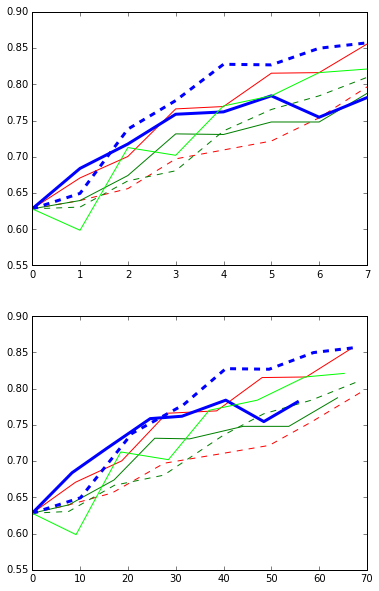

In [622]:
plt.figure(figsize = [6,10])
plt.subplot(2,1,1)
plt.plot(acc_list_rand_4.mean(axis=0),"r-")
plt.plot(acc_list_top_uncertainty_4.mean(axis=0),"r--")
plt.plot(acc_list_S1_3000_top_4.mean(axis=0),"g-")
plt.plot(acc_list_S2_3000_top_4.mean(axis=0),"g--")
plt.plot(acc_list_KM_dist_uncertainty_cost_4.mean(axis=0),"b-",lw=3)
plt.plot(acc_list_KM_dist_uncertainty_no_cost_4.mean(axis=0),"b--",lw=3)
plt.plot(acc_list_Zhu_4.mean(axis=0),c="lime")

plt.subplot(2,1,2)
plt.plot(cost_list_rand_4.mean(axis=0).cumsum(),acc_list_rand_4.mean(axis=0),"r-")
plt.plot(cost_list_top_uncertainty_4.mean(axis=0).cumsum(),acc_list_top_uncertainty_4.mean(axis=0),"r--")
plt.plot(cost_list_S1_3000_top_4.mean(axis=0).cumsum(),acc_list_S1_3000_top_4.mean(axis=0),"g-")
plt.plot(cost_list_S2_3000_top_4.mean(axis=0).cumsum(),acc_list_S2_3000_top_4.mean(axis=0),"g--")
plt.plot(cost_list_KM_dist_uncertainty_cost_4.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost_4.mean(axis=0),"b-",lw=3)
plt.plot(cost_list_KM_dist_uncertainty_no_cost_4.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_no_cost_4.mean(axis=0),"b--",lw=3)
plt.plot(cost_list_Zhu_4.mean(axis=0).cumsum(),acc_list_Zhu_4.mean(axis=0),c="lime")


# 5

In [576]:
begin = time.time()

step = 5
num_loops = 3
N=8

acc_list_rand_5 = np.zeros((num_loops,N))
acc_list_top_uncertainty_5 = np.zeros((num_loops,N))
acc_list_S1_3000_top_5 = np.zeros((num_loops,N))
acc_list_S2_3000_top_5 = np.zeros((num_loops,N))
acc_list_KM_dist_uncertainty_no_cost_5 = np.zeros((num_loops,N))
acc_list_KM_dist_uncertainty_cost_5 = np.zeros((num_loops,N))

cost_list_rand_5 = np.zeros((num_loops,N))
cost_list_top_uncertainty_5 = np.zeros((num_loops,N))
cost_list_S1_3000_top_5 = np.zeros((num_loops,N))
cost_list_S2_3000_top_5 = np.zeros((num_loops,N))
cost_list_KM_dist_uncertainty_no_cost_5 = np.zeros((num_loops,N))
cost_list_KM_dist_uncertainty_cost_5 = np.zeros((num_loops,N))

initial_n_cluster=20


for j in xrange(num_loops):
    print "num_loop = ",j
    
    init_list_5 = random.sample(xrange(data_5_X.shape[0]), 1)
    sp.io.savemat('/Users/xidexia/Desktop/299/lib/semi-supervised/initL_5_'+str(j)+'.mat', {'initL':(np.array(init_list_5)).tolist()})
    
    #####################
    # RAND
    #####################
    print " ***RAND*** "
    X_all = data_5_X_copy
    y_all = data_5_y_copy
        
    labeled_list = init_list_5
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_Rand = RandomForestClassifier(n_estimators=100)
    clf_Rand.fit(Xlabel[:,:2], ylabel)
    
    acc_list_rand_5[j,0] = clf_Rand.score(X_all[:,:2], y_all)
   
    for i in xrange(N-1):
        new_selected_list = random.sample(xrange(Xsearch.shape[0]), step)
        cost_list_rand_5[j,i+1] = Xsearch[new_selected_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[new_selected_list]))   
        ylabel = np.append(ylabel,ysearch[new_selected_list])  
        
        Xsearch = np.delete(np.array(Xsearch),new_selected_list,0)
        ysearch = np.delete(np.array(ysearch),new_selected_list,0)  

        clf_Rand = RandomForestClassifier(n_estimators=100)
        clf_Rand.fit(Xlabel[:,:2], ylabel)

        acc_list_rand_5[j,i+1] = clf_Rand.score(X_all[:,:2], y_all)
    
    
    #####################
    # TOP UNCERTAINTY
    #####################
    print " ***TOP UNCERTAINTY*** "
    X_all = data_5_X_copy
    y_all = data_5_y_copy
        
    labeled_list = init_list_5
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)    
    
    clf_top_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_top_uncertainty.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_top_uncertainty.predict_proba(Xsearch[:,:2])
    max_test_rf_est_list = 1-test_rf_est_list.max(axis=1)

    acc_list_top_uncertainty_5[j,0] = clf_top_uncertainty.score(X_all[:,:2], y_all)
   
    for i in xrange(N-1):
        Uncertainty_label_list = max_test_rf_est_list.argsort()[-step:]
        cost_list_top_uncertainty_5[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()

        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])  
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_top_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_top_uncertainty.fit(Xlabel[:,:2], ylabel)

        test_rf_est_list = clf_top_uncertainty.predict_proba(Xsearch[:,:2])
        max_test_rf_est_list = 1-test_rf_est_list.max(axis=1)

        acc_list_top_uncertainty_5[j,i+1] = clf_top_uncertainty.score(X_all[:,:2], y_all)
    
    
    #####################
    # S1
    #####################
    print " ***S1*** "
    X_all = data_5_X_copy
    y_all = data_5_y_copy
        
    labeled_list = init_list_5
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)    
    
    clf_S1_3000_top = RandomForestClassifier(n_estimators=100)
    clf_S1_3000_top.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_S1_3000_top.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
    
    acc_list_S1_3000_top_5[j,0] = clf_S1_3000_top.score(X_all[:,:2], y_all)
    
    for i in xrange(N-1):
        PXc = clf_S1_3000_top.apply(Xsearch[:,:2])
        PXlabel = clf_S1_3000_top.apply(Xlabel[:,:2])

        S1_list=[]
        for si in xrange(Xsearch.shape[0]):
            sd = sum([100-np.count_nonzero(PXc[si]-PXlabel[sj]) for sj in xrange(Xlabel.shape[0])])/Xlabel.shape[0]
            sn = sum([100-np.count_nonzero(PXc[si]-PXc[sj]) for sj in xrange(PXc.shape[0])])/PXc.shape[0]
            S1_list.append(1.*sn/sd)

        Uncertainty_label_list = np.argsort(S1_list)[-step:]
        cost_list_S1_3000_top_5[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])  
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_S1_3000_top = RandomForestClassifier(n_estimators=100)
        clf_S1_3000_top.fit(Xlabel[:,:2], ylabel)
        
        acc_list_S1_3000_top_5[j,i+1] = clf_S1_3000_top.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_S1_3000_top.predict_proba(Xsearch[:,:2])
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
        
        
    #####################
    # S2
    #####################
    print " ***S2*** "
    X_all = data_5_X_copy
    y_all = data_5_y_copy
        
    labeled_list = init_list_5
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_S2_3000_top = RandomForestClassifier(n_estimators=100)
    clf_S2_3000_top.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_S2_3000_top.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
    
    acc_list_S2_3000_top_5[j,0] = clf_S2_3000_top.score(X_all[:,:2], y_all)
    
    for i in xrange(N-1):
        PXc = clf_S2_3000_top.apply(Xsearch[:,:2])
        PXlabel = clf_S2_3000_top.apply(Xlabel[:,:2])

        S2_list=[]
        for si in xrange(Xsearch.shape[0]):
            sd = sum([100-np.count_nonzero(PXc[si]-PXlabel[sj]) for sj in xrange(Xlabel.shape[0])])+1
            sn = sum([100-np.count_nonzero(PXc[si]-PXc[sj]) for sj in xrange(PXc.shape[0])])*obj_uncertainty_score_list[si]
            S2_list.append(1.*sn/sd)

        Uncertainty_label_list = np.argsort(S2_list)[-step:]
        cost_list_S2_3000_top_5[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
       
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])    
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_S2_3000_top = RandomForestClassifier(n_estimators=100)
        clf_S2_3000_top.fit(Xlabel[:,:2], ylabel)
        
        acc_list_S2_3000_top_5[j,i+1] = clf_S2_3000_top.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_S2_3000_top.predict_proba(Xsearch[:,:2])
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
    
    
    #####################
    # C-BAL NO COST
    #####################
    print " ***C-BAL NO COST*** "
    X_all = data_5_X_copy
    y_all = data_5_y_copy
        
    labeled_list = init_list_5
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
  
    acc_list_KM_dist_uncertainty_no_cost_5[j,0] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
    cost_list_KM_dist_uncertainty_no_cost_5[j,0] = 0
    
    for i in xrange(N-1):
        X = Xsearch[:,:2]
        KMeans_temp = [KMeans(n_clusters = ih, init="k-means++").fit(X) for ih in ks]

        # now run for each cluster the BIC computation
        BIC = [compute_bic(kmeansi,X) for kmeansi in KMeans_temp]
        n_cluster = initial_n_cluster
        if np.argmax(BIC)+1 > step: 
            n_cluster = np.argmax(BIC)+1 
        
        if(Xsearch.shape[0] < n_cluster): break
            
        kmeans = KMeans(init='k-means++', n_clusters=n_cluster, n_init=10)
        kmeans.fit(Xsearch[:,:2])
        center_list = kmeans.cluster_centers_
        label_list = np.array(kmeans.labels_.tolist())
        cluster_obj_table, cluster_score_table = cluster_obj_and_score_tabel_exp(label_list,obj_uncertainty_score_list,n_cluster)
        
        Uncertainty_label_list = selected_obj_list_no_cost(cluster_obj_table,center_list, obj_uncertainty_score_list, Xsearch,step)       
        cost_list_KM_dist_uncertainty_no_cost_5[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])    
            
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
        
        acc_list_KM_dist_uncertainty_no_cost_5[j,i+1] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])   
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
            
    #####################
    # C-BAL COST
    #####################
    print " ***C-BAL COST*** "
    X_all = data_5_X_copy
    y_all = data_5_y_copy
        
    labeled_list = init_list_5
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
    
    test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])
    obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
  
    acc_list_KM_dist_uncertainty_cost_5[j,0] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
    cost_list_KM_dist_uncertainty_cost_5[j,0] = 0
    
    for i in xrange(N-1):
        X = Xsearch[:,:2]
        KMeans_temp = [KMeans(n_clusters = ih, init="k-means++").fit(X) for ih in ks]

        # now run for each cluster the BIC computation
        BIC = [compute_bic(kmeansi,X) for kmeansi in KMeans_temp]
        n_cluster = initial_n_cluster
        if np.argmax(BIC)+1 > step: 
            n_cluster = np.argmax(BIC)+1 
        
        if(Xsearch.shape[0] < n_cluster): break
            
        kmeans = KMeans(init='k-means++', n_clusters=n_cluster, n_init=10)
        kmeans.fit(Xsearch[:,:2])
        center_list = kmeans.cluster_centers_
        label_list = np.array(kmeans.labels_.tolist())
        cluster_obj_table, cluster_score_table = cluster_obj_and_score_tabel_exp(label_list,obj_uncertainty_score_list,n_cluster)
        Uncertainty_label_list = selected_obj_list_cost(cluster_obj_table,center_list, obj_uncertainty_score_list, Xsearch,step)
        cost_list_KM_dist_uncertainty_cost_5[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])         
        
        Xsearch = np.delete(np.array(Xsearch),Uncertainty_label_list,0)
        ysearch = np.delete(np.array(ysearch),Uncertainty_label_list,0)  

        clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_KM_dist_uncertainty.fit(Xlabel[:,:2], ylabel)
        
        acc_list_KM_dist_uncertainty_cost_5[j,i+1] = clf_KM_dist_uncertainty.score(X_all[:,:2], y_all)
        
        test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:2])   
        obj_uncertainty_score_list = 1 - test_rf_est_list.max(axis=1)
        
 
print 'Time Elapsed:', time.time()-begin 

num_loop =  0
 ***RAND*** 
 ***TOP UNCERTAINTY*** 
 ***S1*** 
 ***S2*** 
 ***C-BAL NO COST*** 
 ***C-BAL COST*** 
num_loop =  1
 ***RAND*** 
 ***TOP UNCERTAINTY*** 
 ***S1*** 
 ***S2*** 
 ***C-BAL NO COST*** 
 ***C-BAL COST*** 
num_loop =  2
 ***RAND*** 
 ***TOP UNCERTAINTY*** 
 ***S1*** 
 ***S2*** 
 ***C-BAL NO COST*** 
 ***C-BAL COST*** 
Time Elapsed: 155.55348587


In [623]:

step = 5
num_loops = 3
N=8

acc_list_Zhu_5 = np.zeros((num_loops,N))
cost_list_Zhu_5 = np.zeros((num_loops,N))

begin = time.time()

for j in xrange(num_loops):
    #####################
    # ZHU
    #####################
    print " ***ZHU*** "
    query0 = sp.io.loadmat('/Users/xidexia/Desktop/query5_'+str(j)+'.mat')['query5_'+str(j)][0]
    
    X_all = data_5_X_copy
    y_all = data_5_y_copy
        
    labeled_list = sp.io.loadmat('/Users/xidexia/Desktop/299/lib/semi-supervised/initL_5_'+str(j)+'.mat')['initL'][0]
    Xlabel = X_all[labeled_list]
    ylabel = y_all[labeled_list]
    
    Xsearch = np.delete(np.array(X_all),labeled_list,0)
    ysearch = np.delete(np.array(y_all),labeled_list,0)  
    
    clf_Rand = RandomForestClassifier(n_estimators=100)
    clf_Rand.fit(Xlabel[:,:2], ylabel)
    
    acc_list_Zhu_5[j,0] = clf_Rand.score(X_all[:,:2], y_all)
  
    for i in xrange(N-1):
        Uncertainty_label_list = query0[i*step:i*step+step]-1
        #print Uncertainty_label_list
        cost_list_Zhu_5[j,i+1] = X_all[Uncertainty_label_list,-1].sum()
        Xlabel = np.vstack((Xlabel,X_all[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,y_all[Uncertainty_label_list])    
        
        clf_Rand = RandomForestClassifier(n_estimators=100)
        clf_Rand.fit(Xlabel[:,:2], ylabel)

        acc_list_Zhu_5[j,i+1] = clf_Rand.score(X_all[:,:2], y_all)
 
print 'Time Elapsed:', time.time()-begin 

 ***ZHU*** 
 ***ZHU*** 
 ***ZHU*** 
Time Elapsed: 1.82124400139


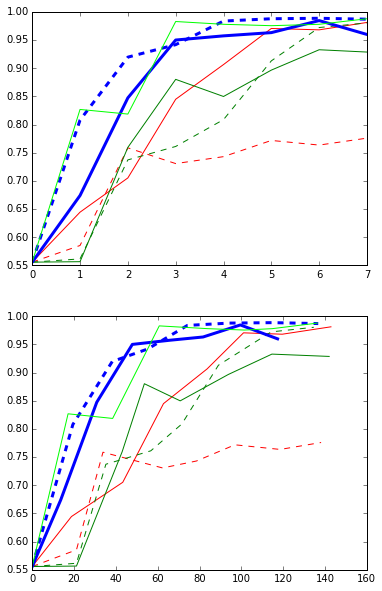

In [624]:
plt.figure(figsize = [6,10])
plt.subplot(2,1,1)
plt.plot(acc_list_rand_5.mean(axis=0),"r-")
plt.plot(acc_list_top_uncertainty_5.mean(axis=0),"r--")
plt.plot(acc_list_S1_3000_top_5.mean(axis=0),"g-")
plt.plot(acc_list_S2_3000_top_5.mean(axis=0),"g--")
plt.plot(acc_list_KM_dist_uncertainty_cost_5.mean(axis=0),"b-",lw=3)
plt.plot(acc_list_KM_dist_uncertainty_no_cost_5.mean(axis=0),"b--",lw=3)
plt.plot(acc_list_Zhu_5.mean(axis=0),c="lime")

plt.subplot(2,1,2)
plt.plot(cost_list_rand_5.mean(axis=0).cumsum(),acc_list_rand_5.mean(axis=0),"r-")
plt.plot(cost_list_top_uncertainty_5.mean(axis=0).cumsum(),acc_list_top_uncertainty_5.mean(axis=0),"r--")
plt.plot(cost_list_S1_3000_top_5.mean(axis=0).cumsum(),acc_list_S1_3000_top_5.mean(axis=0),"g-")
plt.plot(cost_list_S2_3000_top_5.mean(axis=0).cumsum(),acc_list_S2_3000_top_5.mean(axis=0),"g--")
plt.plot(cost_list_KM_dist_uncertainty_cost_5.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost_5.mean(axis=0),"b-",lw=3)
plt.plot(cost_list_KM_dist_uncertainty_no_cost_5.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_no_cost_5.mean(axis=0),"b--",lw=3)
plt.plot(cost_list_Zhu_5.mean(axis=0).cumsum(),acc_list_Zhu_5.mean(axis=0),c="lime")


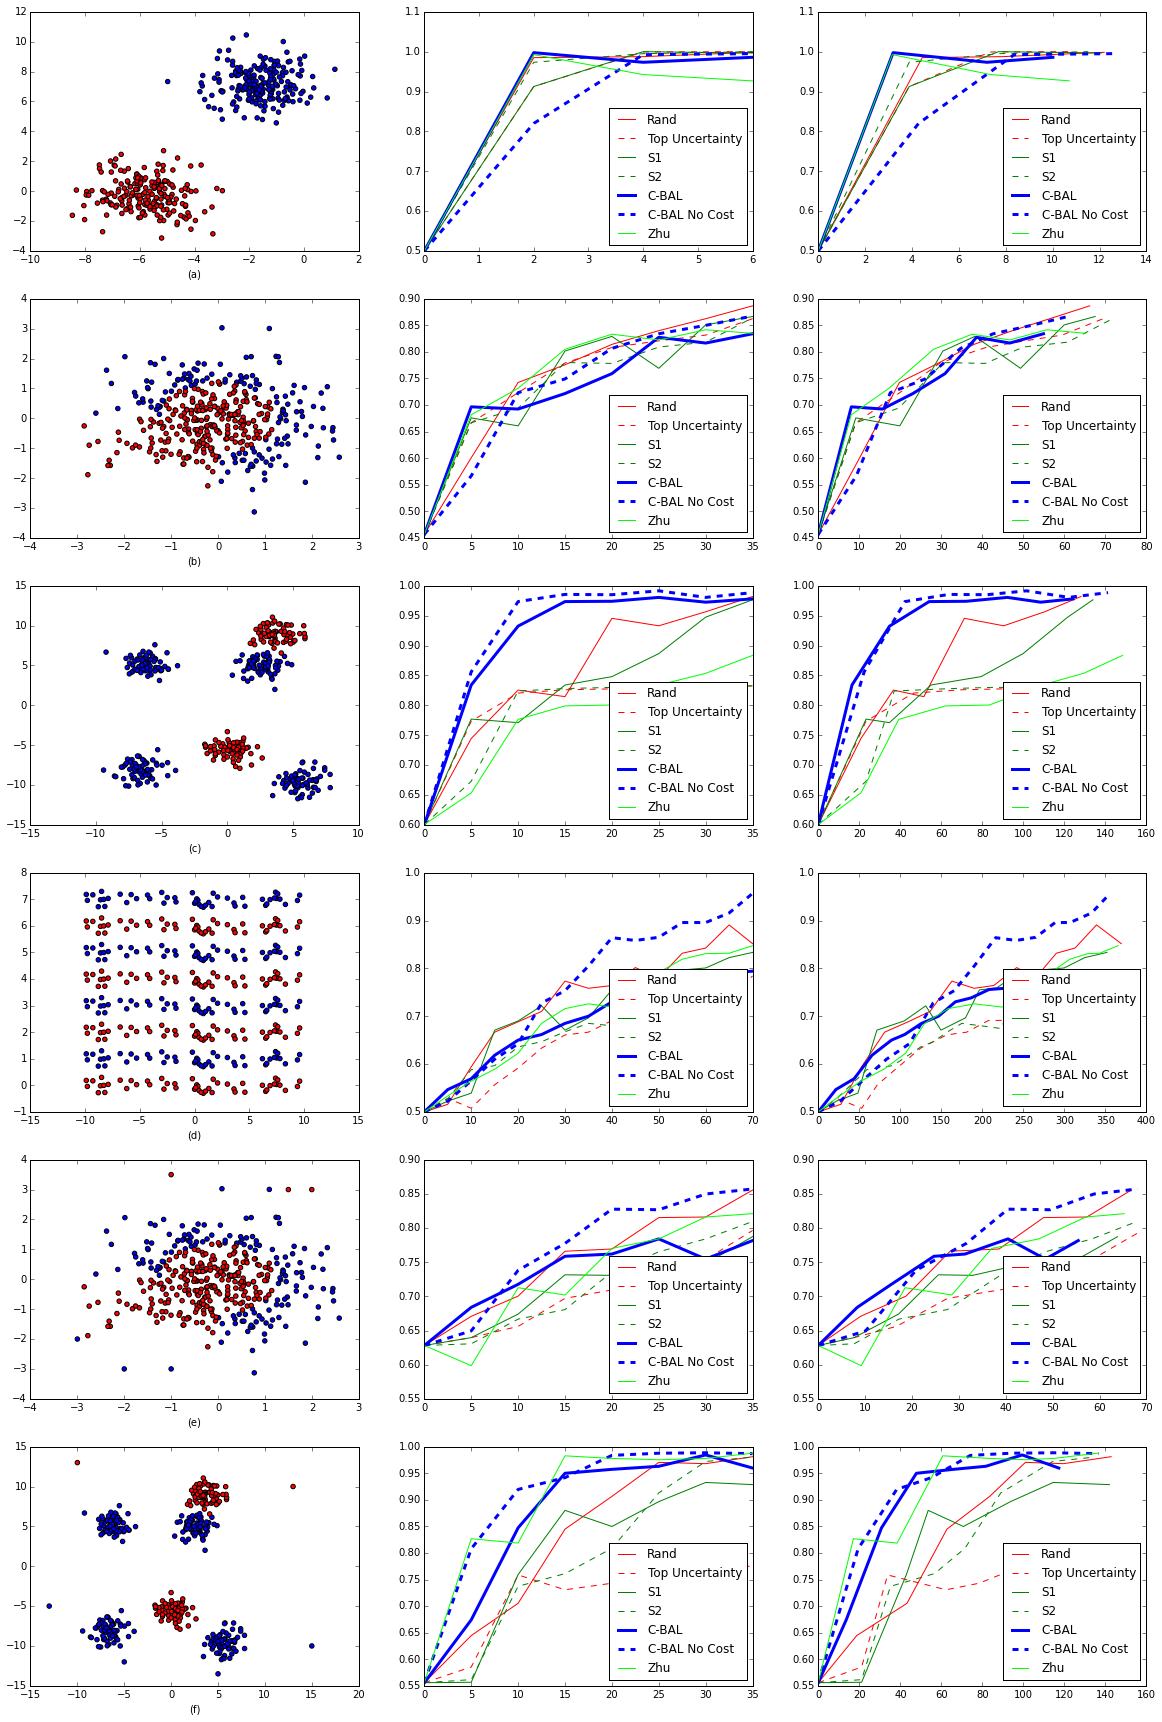

In [625]:
plt.figure(figsize = [20,30])
plt.subplot(6,3,1)
cc=[color[i] for i in data_0_y]
plt.scatter(data_0_X[:,0],data_0_X[:,1],c=cc)
plt.xlabel("(a)")
#plt.scatter(Xinit_0[:,0],Xinit_0[:,1],c="lime",s=50)

plt.subplot(6,3,2)
xx=np.arange(4)*2
plt.plot(xx, acc_list_rand_0.mean(axis=0),"r-",label="Rand")
plt.plot(xx, acc_list_top_uncertainty_0.mean(axis=0),"r--",label="Top Uncertainty")
plt.plot(xx, acc_list_S1_3000_top_0.mean(axis=0),"g-",label="S1")
plt.plot(xx, acc_list_S2_3000_top_0.mean(axis=0),"g--",label="S2")
plt.plot(xx, acc_list_KM_dist_uncertainty_cost_0.mean(axis=0),"b-",lw=3,label="C-BAL")
plt.plot(xx, acc_list_KM_dist_uncertainty_no_cost_0.mean(axis=0),"b--",lw=3,label="C-BAL No Cost")
plt.plot(xx, acc_list_Zhu_0.mean(axis=0),c="lime",label="Zhu")
plt.legend(loc=4)

plt.subplot(6,3,3)
plt.plot(cost_list_rand_0.mean(axis=0).cumsum(),acc_list_rand_0.mean(axis=0),"r-",label="Rand")
plt.plot(cost_list_top_uncertainty_0.mean(axis=0).cumsum(),acc_list_top_uncertainty_0.mean(axis=0),"r--",label="Top Uncertainty")
plt.plot(cost_list_S1_3000_top_0.mean(axis=0).cumsum(),acc_list_S1_3000_top_0.mean(axis=0),"g-",label="S1")
plt.plot(cost_list_S2_3000_top_0.mean(axis=0).cumsum(),acc_list_S2_3000_top_0.mean(axis=0),"g--",label="S2")
plt.plot(cost_list_KM_dist_uncertainty_cost_0.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost_0.mean(axis=0),"b-",lw=3,label="C-BAL")
plt.plot(cost_list_KM_dist_uncertainty_no_cost_0.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_no_cost_0.mean(axis=0),"b--",lw=3,label="C-BAL No Cost")
plt.plot(cost_list_Zhu_0.mean(axis=0).cumsum(),acc_list_Zhu_0.mean(axis=0),c="lime",label="Zhu")
plt.legend(loc=4)

plt.subplot(6,3,4)
cc=[color[i] for i in data_1_y]
plt.scatter(data_1_X[:,0],data_1_X[:,1],c=cc)
plt.xlabel("(b)")
#plt.scatter(Xinit_1[:,0],Xinit_1[:,1],c="lime",s=50)

plt.subplot(6,3,5)
xx=np.arange(8)*5
plt.plot(xx, acc_list_rand_1.mean(axis=0),"r-",label="Rand")
plt.plot(xx, acc_list_top_uncertainty_1.mean(axis=0),"r--",label="Top Uncertainty")
plt.plot(xx, acc_list_S1_3000_top_1.mean(axis=0),"g-",label="S1")
plt.plot(xx, acc_list_S2_3000_top_1.mean(axis=0),"g--",label="S2")
plt.plot(xx, acc_list_KM_dist_uncertainty_cost_1.mean(axis=0),"b-",lw=3,label="C-BAL")
plt.plot(xx, acc_list_KM_dist_uncertainty_no_cost_1.mean(axis=0),"b--",lw=3,label="C-BAL No Cost")
plt.plot(xx, acc_list_Zhu_1.mean(axis=0),c="lime",label="Zhu")
plt.legend(loc=4)

plt.subplot(6,3,6)
plt.plot(cost_list_rand_1.mean(axis=0).cumsum(),acc_list_rand_1.mean(axis=0),"r-",label="Rand")
plt.plot(cost_list_top_uncertainty_1.mean(axis=0).cumsum(),acc_list_top_uncertainty_1.mean(axis=0),"r--",label="Top Uncertainty")
plt.plot(cost_list_S1_3000_top_1.mean(axis=0).cumsum(),acc_list_S1_3000_top_1.mean(axis=0),"g-",label="S1")
plt.plot(cost_list_S2_3000_top_1.mean(axis=0).cumsum(),acc_list_S2_3000_top_1.mean(axis=0),"g--",label="S2")
plt.plot(cost_list_KM_dist_uncertainty_cost_1.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost_1.mean(axis=0),"b-",lw=3,label="C-BAL")
plt.plot(cost_list_KM_dist_uncertainty_no_cost_1.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_no_cost_1.mean(axis=0),"b--",lw=3,label="C-BAL No Cost")
plt.plot(cost_list_Zhu_1.mean(axis=0).cumsum(),acc_list_Zhu_1.mean(axis=0),c="lime",label="Zhu")
plt.legend(loc=4)

plt.subplot(6,3,7)
cc=[color[i] for i in data_2_y]
plt.scatter(data_2_X[:,0],data_2_X[:,1],c=cc)
plt.xlabel("(c)")
#plt.scatter(Xinit_2[:,0],Xinit_2[:,1],c="lime",s=50)

plt.subplot(6,3,8)
xx=np.arange(8)*5
plt.plot(xx, acc_list_rand_2.mean(axis=0),"r-",label="Rand")
plt.plot(xx, acc_list_top_uncertainty_2.mean(axis=0),"r--",label="Top Uncertainty")
plt.plot(xx, acc_list_S1_3000_top_2.mean(axis=0),"g-",label="S1")
plt.plot(xx, acc_list_S2_3000_top_2.mean(axis=0),"g--",label="S2")
plt.plot(xx, acc_list_KM_dist_uncertainty_cost_2.mean(axis=0),"b-",lw=3,label="C-BAL")
plt.plot(xx, acc_list_KM_dist_uncertainty_no_cost_2.mean(axis=0),"b--",lw=3,label="C-BAL No Cost")
plt.plot(xx, acc_list_Zhu_2.mean(axis=0),c="lime",label="Zhu")
plt.legend(loc=4)

plt.subplot(6,3,9)
plt.plot(cost_list_rand_2.mean(axis=0).cumsum(),acc_list_rand_2.mean(axis=0),"r-",label="Rand")
plt.plot(cost_list_top_uncertainty_2.mean(axis=0).cumsum(),acc_list_top_uncertainty_2.mean(axis=0),"r--",label="Top Uncertainty")
plt.plot(cost_list_S1_3000_top_2.mean(axis=0).cumsum(),acc_list_S1_3000_top_2.mean(axis=0),"g-",label="S1")
plt.plot(cost_list_S2_3000_top_2.mean(axis=0).cumsum(),acc_list_S2_3000_top_2.mean(axis=0),"g--",label="S2")
plt.plot(cost_list_KM_dist_uncertainty_cost_2.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost_2.mean(axis=0),"b-",lw=3,label="C-BAL")
plt.plot(cost_list_KM_dist_uncertainty_no_cost_2.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_no_cost_2.mean(axis=0),"b--",lw=3,label="C-BAL No Cost")
plt.plot(cost_list_Zhu_2.mean(axis=0).cumsum(),acc_list_Zhu_2.mean(axis=0),c="lime",label="Zhu")
plt.legend(loc=4)

plt.subplot(6,3,10)
cc=[color[i] for i in data_3_y]
plt.scatter(data_3_X[:,0],data_3_X[:,1],c=cc)
plt.xlabel("(d)")
#plt.scatter(Xinit_3[:,0],Xinit_3[:,1],c="lime",s=50)

plt.subplot(6,3,11)
xx=np.arange(15)*5
plt.plot(xx, acc_list_rand_3.mean(axis=0),"r-",label="Rand")
plt.plot(xx, acc_list_top_uncertainty_3.mean(axis=0),"r--",label="Top Uncertainty")
plt.plot(xx, acc_list_S1_3000_top_3.mean(axis=0),"g-",label="S1")
plt.plot(xx, acc_list_S2_3000_top_3.mean(axis=0),"g--",label="S2")
plt.plot(xx, acc_list_KM_dist_uncertainty_cost_3.mean(axis=0),"b-",lw=3,label="C-BAL")
plt.plot(xx, acc_list_KM_dist_uncertainty_no_cost_3.mean(axis=0),"b--",lw=3,label="C-BAL No Cost")
plt.plot(xx, acc_list_Zhu_3.mean(axis=0),c="lime",label="Zhu")
plt.legend(loc=4)

plt.subplot(6,3,12)
plt.plot(cost_list_rand_3.mean(axis=0).cumsum(),acc_list_rand_3.mean(axis=0),"r-",label="Rand")
plt.plot(cost_list_top_uncertainty_3.mean(axis=0).cumsum(),acc_list_top_uncertainty_3.mean(axis=0),"r--",label="Top Uncertainty")
plt.plot(cost_list_S1_3000_top_3.mean(axis=0).cumsum(),acc_list_S1_3000_top_3.mean(axis=0),"g-",label="S1")
plt.plot(cost_list_S2_3000_top_3.mean(axis=0).cumsum(),acc_list_S2_3000_top_3.mean(axis=0),"g--",label="S2")
plt.plot(cost_list_KM_dist_uncertainty_cost_3.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost_3.mean(axis=0),"b-",lw=3,label="C-BAL")
plt.plot(cost_list_KM_dist_uncertainty_no_cost_3.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_no_cost_3.mean(axis=0),"b--",lw=3,label="C-BAL No Cost")
plt.plot(cost_list_Zhu_3.mean(axis=0).cumsum(),acc_list_Zhu_3.mean(axis=0),c="lime",label="Zhu")
plt.legend(loc=4)

plt.subplot(6,3,13)
cc=[color[i] for i in data_4_y]
plt.scatter(data_4_X[:,0],data_4_X[:,1],c=cc)
plt.xlabel("(e)")
#plt.scatter(Xinit_4[:,0],Xinit_4[:,1],c="lime",s=50)

plt.subplot(6,3,14)
xx=np.arange(8)*5
plt.plot(xx, acc_list_rand_4.mean(axis=0),"r-",label="Rand")
plt.plot(xx, acc_list_top_uncertainty_4.mean(axis=0),"r--",label="Top Uncertainty")
plt.plot(xx, acc_list_S1_3000_top_4.mean(axis=0),"g-",label="S1")
plt.plot(xx, acc_list_S2_3000_top_4.mean(axis=0),"g--",label="S2")
plt.plot(xx, acc_list_KM_dist_uncertainty_cost_4.mean(axis=0),"b-",lw=3,label="C-BAL")
plt.plot(xx, acc_list_KM_dist_uncertainty_no_cost_4.mean(axis=0),"b--",lw=3,label="C-BAL No Cost")
plt.plot(xx, acc_list_Zhu_4.mean(axis=0),c="lime",label="Zhu")
plt.legend(loc=4)

plt.subplot(6,3,15)
plt.plot(cost_list_rand_4.mean(axis=0).cumsum(),acc_list_rand_4.mean(axis=0),"r-",label="Rand")
plt.plot(cost_list_top_uncertainty_4.mean(axis=0).cumsum(),acc_list_top_uncertainty_4.mean(axis=0),"r--",label="Top Uncertainty")
plt.plot(cost_list_S1_3000_top_4.mean(axis=0).cumsum(),acc_list_S1_3000_top_4.mean(axis=0),"g-",label="S1")
plt.plot(cost_list_S2_3000_top_4.mean(axis=0).cumsum(),acc_list_S2_3000_top_4.mean(axis=0),"g--",label="S2")
plt.plot(cost_list_KM_dist_uncertainty_cost_4.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost_4.mean(axis=0),"b-",lw=3,label="C-BAL")
plt.plot(cost_list_KM_dist_uncertainty_no_cost_4.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_no_cost_4.mean(axis=0),"b--",lw=3,label="C-BAL No Cost")
plt.plot(cost_list_Zhu_4.mean(axis=0).cumsum(),acc_list_Zhu_4.mean(axis=0),c="lime",label="Zhu")
plt.legend(loc=4)

plt.subplot(6,3,16)
cc=[color[i] for i in data_5_y]
plt.scatter(data_5_X[:,0],data_5_X[:,1],c=cc)
plt.xlabel("(f)")
#plt.scatter(Xinit_5[:,0],Xinit_5[:,1],c="lime",s=50)

plt.subplot(6,3,17)
xx=np.arange(8)*5
plt.plot(xx, acc_list_rand_5.mean(axis=0),"r-",label="Rand")
plt.plot(xx, acc_list_top_uncertainty_5.mean(axis=0),"r--",label="Top Uncertainty")
plt.plot(xx, acc_list_S1_3000_top_5.mean(axis=0),"g-",label="S1")
plt.plot(xx, acc_list_S2_3000_top_5.mean(axis=0),"g--",label="S2")
plt.plot(xx, acc_list_KM_dist_uncertainty_cost_5.mean(axis=0),"b-",lw=3,label="C-BAL")
plt.plot(xx, acc_list_KM_dist_uncertainty_no_cost_5.mean(axis=0),"b--",lw=3,label="C-BAL No Cost")
plt.plot(xx, acc_list_Zhu_5.mean(axis=0),c="lime",label="Zhu")
plt.legend(loc=4)

plt.subplot(6,3,18)
plt.plot(cost_list_rand_5.mean(axis=0).cumsum(),acc_list_rand_5.mean(axis=0),"r-",label="Rand")
plt.plot(cost_list_top_uncertainty_5.mean(axis=0).cumsum(),acc_list_top_uncertainty_5.mean(axis=0),"r--",label="Top Uncertainty")
plt.plot(cost_list_S1_3000_top_5.mean(axis=0).cumsum(),acc_list_S1_3000_top_5.mean(axis=0),"g-",label="S1")
plt.plot(cost_list_S2_3000_top_5.mean(axis=0).cumsum(),acc_list_S2_3000_top_5.mean(axis=0),"g--",label="S2")
plt.plot(cost_list_KM_dist_uncertainty_cost_5.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost_5.mean(axis=0),"b-",lw=3,label="C-BAL")
plt.plot(cost_list_KM_dist_uncertainty_no_cost_5.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_no_cost_5.mean(axis=0),"b--",lw=3,label="C-BAL No Cost")
plt.plot(cost_list_Zhu_5.mean(axis=0).cumsum(),acc_list_Zhu_5.mean(axis=0),c="lime",label="Zhu")
plt.legend(loc=4)